In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
import sys
sys.path.append('../src/')

In [3]:
# set plotting params
import matplotlib as mpl
import plots
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.reload_library()
rcparams = plots.stdrcparams()
mpl.rcParams.update(rcparams)

from preprocess import *

In [4]:
import itertools
import plotly.graph_objects as go
from scipy.stats import linregress, entropy
from sklearn.datasets import make_classification
from sklearn.metrics import silhouette_score, adjusted_rand_score, mutual_info_score, adjusted_mutual_info_score, normalized_mutual_info_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, KBinsDiscretizer, RobustScaler
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

In [6]:
carpediem_dir = r'../data/carpediem'
curated_dir = r'../data/curated'
mimic_dir = r'../data/mimiciv_included'
dp_dir = r'../data/calculated/dp'

# script

In [7]:
dfs = []
for filename in os.listdir(os.path.join(dp_dir, '240521_holdout')):
    if filename.startswith('carpediem')&('CarryLastForward_limit2_' in filename):
        parts = filename.replace('carpediem_', '').replace('CarryLastForward_limit2_', '').replace('.csv', '').split('_')
        # print(parts)
        feature_set = parts[0]
        scaler_name = parts[1]
        n_pc = parts[2].replace('PC', '')
        boot = parts[-1].replace('boot', '').replace('pdist', 'all')

        file_path = os.path.join(dp_dir, '240521_holdout', filename)

        df = pd.read_csv(file_path, index_col=0)
        df['dataset'] = 'carpediem'
        df['feature_set'] = feature_set
        df['n_pc'] = n_pc
        df['boot'] = boot

        dfs.append(df)
        # break
    # break


In [8]:
dps = pd.concat(dfs, ignore_index=True)
# dps.drop(columns=['index'], inplace=True)

In [9]:
def edpc(dps, feature_set, n_cmp, n_pc, se=99):
    f1 = dps.feature_set==feature_set
    f2 = dps.boot=='all'
    f3 = dps.n_pc == str(n_pc)
    cc = dps[f1&f3].sort_values('rd', ascending=False).iloc[:n_cmp*101][[f'PC{i}' for i in range(1,n_pc+1)]]
    cc = cc.drop_duplicates()
    km = KMeans(n_clusters=n_cmp, random_state=0, n_init=5).fit(cc.values)
    gm = GaussianMixture(n_components=n_cmp, means_init=km.cluster_centers_, fix_means=True, random_state=se).fit(dps.loc[f1&f2&f3, [f'PC{i}' for i in range(1,n_pc+1)]])
    gm_pred = gm.predict(dps.loc[f1&f2&f3, [f'PC{i}' for i in range(1,n_pc+1)]])
    gm_scr = gm.score_samples(dps.loc[f1&f2&f3, [f'PC{i}' for i in range(1,n_pc+1)]])
    dps.loc[f1&f2&f3, f'{feature_set}_pred'] = gm_pred
    dps.loc[f1&f2&f3, f'{feature_set}_scr'] = gm_scr
    return dps, gm

In [10]:
out, gm_script_sofs = edpc(dps, 'sofs', 4, 2)
out, gm_script_sofs_vtls = edpc(out, 'sofs+vtls', 5, 4)
out, gm_script_sofs_vtls_dmos1 = edpc(out, 'sofs+vtls+dmos1', 3, 5)
out, gm_script_sofs_vtls_dmos1_lbs1 = edpc(out, 'sofs+vtls+dmos1+lbs1', 5, 6)
# out = edpc(out, 'sofs+vtls+dmos1+lbs1+vents', 2, 8)
# out = edpc(out, 'sofs+vtls+dmos1+lbs2', 3, 9)

In [11]:
out = out[out.boot=='all'][list(out.columns[:3]) + list(out.columns[22:])]

In [12]:
out = out[['Patient_id', 'ICU_stay', 'ICU_day', 'sofs_pred', 'sofs_scr']].dropna().merge(
    out[['Patient_id', 'ICU_stay', 'ICU_day', 'sofs+vtls_pred', 'sofs+vtls_scr']].dropna(), how='outer').merge(
    out[['Patient_id', 'ICU_stay', 'ICU_day', 'sofs+vtls+dmos1_pred', 'sofs+vtls+dmos1_scr']].dropna(), how='outer').merge(
    out[['Patient_id', 'ICU_stay', 'ICU_day', 'sofs+vtls+dmos1+lbs1_pred', 'sofs+vtls+dmos1+lbs1_scr']].dropna(), how='outer')#.merge(
    # out[['Patient_id', 'ICU_stay', 'ICU_day', 'sofs+vtls+dmos1+lbs1+vents_pred', 'sofs+vtls+dmos1+lbs1+vents_scr']].dropna(), how='outer').merge(
    # out[['Patient_id', 'ICU_stay', 'ICU_day', 'sofs+vtls+dmos1+lbs2_pred', 'sofs+vtls+dmos1+lbs2_scr']].dropna(), how='outer')

In [13]:
carpediem, carpediem2 = load_carpediem()
carpediem = carpediem_icu(carpediem, carpediem2)

carpediem = carpediem_edps(carpediem)

In [14]:
out = out.merge(carpediem, how='outer', on=['Patient_id', 'ICU_stay', 'ICU_day'])

In [15]:
out = out.sort_values(['Patient_id', 'ICU_stay', 'ICU_day'])

In [16]:
pred_cols = [i for i in out.columns if 'pred' in i]
for i in pred_cols:
    tmp = (out[out['edps'] == 'dying'].groupby(i).size() / out.groupby(i).size()).reset_index(name='mortality_24h').fillna(0).sort_values('mortality_24h')
    mapping = {cluster: f'C{j+1}' for j, cluster in enumerate(tmp[i])} 
    print(mapping, '\n', i)
    out[i] = out[i].map(mapping)
    # out[i] = pd.Categorical(out[i], categories=mapping.values(), ordered=True)

{2.0: 'C1', 1.0: 'C2', 3.0: 'C3', 0.0: 'C4'} 
 sofs_pred
{0.0: 'C1', 2.0: 'C2', 4.0: 'C3', 3.0: 'C4', 1.0: 'C5'} 
 sofs+vtls_pred
{2.0: 'C1', 1.0: 'C2', 0.0: 'C3'} 
 sofs+vtls+dmos1_pred
{2.0: 'C1', 4.0: 'C2', 0.0: 'C3', 3.0: 'C4', 1.0: 'C5'} 
 sofs+vtls+dmos1+lbs1_pred


In [17]:
out_script = out.copy()

## test set

In [18]:
script_train, script_test = load_and_prepare_dataset(dataset='carpediem', feature_set='sofs+vtls', \
                                imputation_strategy='CarryLastForward_limit2', scaler_name='KBD', holdout=.1)

In [19]:
pcaX, pca, loadings, top_features = perform_pca(data=script_train.iloc[:,:-1], n_components=script_train.shape[1]-1, plot=False)

In [20]:
out_script_test = pd.DataFrame(pca.transform(script_test.iloc[:,:-1])[:,:4], columns=[f'PC{i}' for i in np.arange(1,5)], index=script_test.index).reset_index()

In [21]:
n_pc=4
out_script_test['sofs+vtls_pred'] = gm_script_sofs_vtls.predict(out_script_test.loc[:, [f'PC{i}' for i in np.arange(1,n_pc+1)]])
out_script_test['sofs+vtls_scr'] = gm_script_sofs_vtls.score_samples(out_script_test.loc[:, [f'PC{i}' for i in np.arange(1,n_pc+1)]])

In [22]:
out_script_test['sofs+vtls_pred'] = out_script_test['sofs+vtls_pred'].map({0.0: 'C1', 2.0: 'C2', 4.0: 'C3', 3.0: 'C4', 1.0: 'C5'} )

In [23]:
out_script_test = out_script_test.merge(carpediem, how='outer', on=['Patient_id', 'ICU_stay', 'ICU_day']).sort_values(['Patient_id', 'ICU_stay', 'ICU_day'])

## episodes

In [24]:
def impute_episodes(group):
    group = group.copy() 
    episode_id = 0 # Make a copy to avoid SettingWithCopyWarning
    for idx, row in group.iterrows():
        if pd.notna(row['Episode_duration']):
            # Get the number of days to forward fill
            duration = int(row['Episode_duration'])
            episode_id += 1
            # Forward fill the category and etiology for the duration specified
            end_day = row['ICU_day'] + duration
            fill_idx = group[(group['ICU_day'] >= row['ICU_day']) & (group['ICU_day'] <= end_day)].index
            group.loc[fill_idx, 'Episode_category'] = row['Episode_category']
            group.loc[fill_idx, 'Episode_etiology'] = row['Episode_etiology']
            group.loc[fill_idx, 'Episode_is_cured'] = row['Episode_is_cured']
            group.loc[fill_idx, 'episode_id'] = episode_id
        elif pd.notna(row['Episode_category']) and pd.isna(row['Episode_duration']):
            episode_id += 1
            # If the episode has no duration, fill the category and etiology until the next episode
            next_idx = group.loc[idx+1:].index
            if group.loc[next_idx, 'Episode_category'].notna().any():
                next_idx = next_idx[group.loc[next_idx, 'Episode_category'].notna()].min()
            else:
                next_idx = next_idx.max()
            group.loc[idx:next_idx, 'Episode_category'] = row['Episode_category']
            group.loc[idx:next_idx, 'Episode_etiology'] = row['Episode_etiology']
            group.loc[idx:next_idx, 'Episode_is_cured'] = row['Episode_is_cured']
            group.loc[idx:next_idx, 'episode_id'] = episode_id
    return group

In [25]:
out_script_train = out_script.groupby(['Patient_id', 'ICU_stay']).apply(impute_episodes, include_groups=False).reset_index().drop(columns='level_2')
out_script_test = out_script_test.groupby(['Patient_id', 'ICU_stay']).apply(impute_episodes, include_groups=False).reset_index().drop(columns='level_2')

In [26]:
def check_continuous(group):
    return (group['ICU_day'].diff().dropna() == 1).all()

print(out_script_train.sort_values('ICU_day').groupby(['Patient_id', 'ICU_stay']).apply(check_continuous, include_groups=False).all())
print(out_script_test.sort_values('ICU_day').groupby(['Patient_id', 'ICU_stay']).apply(check_continuous, include_groups=False).all())

True
True


In [27]:
out_script_train = out_script_train.assign(epi_etio_next_day=out_script_train.groupby(['Patient_id', 'ICU_stay'])['Episode_etiology'].shift(-1))
out_script_test = out_script_test.assign(epi_etio_next_day=out_script_test.groupby(['Patient_id', 'ICU_stay'])['Episode_etiology'].shift(-1))

In [28]:
out_script_train = out_script_train[out_script_train['Patient_id'].isin(script_train.reset_index()['Patient_id'])].reset_index(drop=True).sort_values(['Patient_id', 'ICU_stay', 'ICU_day'])
out_script_train = out_script_train.merge(pcaX, how='outer', on=['Patient_id', 'ICU_stay', 'ICU_day']).sort_values(['Patient_id', 'ICU_stay', 'ICU_day'])
out_script_test = out_script_test[out_script_test['Patient_id'].isin(script_test.reset_index()['Patient_id'])].reset_index(drop=True).sort_values(['Patient_id', 'ICU_stay', 'ICU_day'])

# mimic

In [29]:
mimic_test_raw = load_and_prepare_dataset(dataset='mimic', feature_set='sofs+vtls', \
                                imputation_strategy='Complete_cases', scaler_name='Raw', holdout=False)

# mimic_train_raw, mimic_test_raw = load_and_prepare_dataset(dataset='mimic', feature_set='sofs+vtls', \
#                                 imputation_strategy='Complete_cases', scaler_name='Raw', holdout=.5)

script_train_raw, script_test_raw = load_and_prepare_dataset(dataset='carpediem', feature_set='sofs+vtls', \
                                imputation_strategy='CarryLastForward_limit2', scaler_name='Raw', holdout=.1)

In [30]:
mapping_dict = {
    'respiration_24hours': 'P_F_ratio_points',
    'coagulation_24hours': 'platelet_points',
    'liver_24hours': 'bilirubin_points',
    'cardiovascular_24hours': 'htn_points',
    'gcs_motor': 'GCS_motor_response',
    'gcs_verbal': 'GCS_verbal_response',
    'gcs_eyes': 'GCS_eye_opening',
    'renal_24hours': 'renal_points',
    'heart_rate': 'Heart_rate',
    'sbp': 'Systolic_blood_pressure',
    'dbp': 'Diastolic_blood_pressure',
    'mbp': 'Mean_arterial_pressure',
    'resp_rate': 'Respiratory_rate',
    'temperature': 'Temperature',
    'spo2': 'Oxygen_saturation'
}

In [31]:
mimic_test_raw = mimic_test_raw.rename(columns=mapping_dict)[script_train_raw.columns]

In [32]:
scaler = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy='quantile')
scaler.fit(script_train_raw.iloc[:, 8:-1])
# script_train_raw.iloc[:, 8:-1] = script_train_raw.transform(script_train_raw.iloc[:, 8:-1])
mimic_test_raw.iloc[:, 8:-1] = scaler.transform(mimic_test_raw.iloc[:, 8:-1])

In [33]:
Carpediem_fit_pca_transform_mimic = pca.transform(mimic_test_raw.iloc[:,:-1])
out_mimic_test = pd.DataFrame(Carpediem_fit_pca_transform_mimic, columns=[f'PC{i}' for i in np.arange(1,script_train.shape[1])], index=mimic_test_raw.index)

In [34]:
n_pc=4
out_mimic_test['script_pred'] = gm_script_sofs_vtls.predict(out_mimic_test.loc[:, [f'PC{i}' for i in np.arange(1,n_pc+1)]])
out_mimic_test['script_pred'] = out_mimic_test['script_pred'].map({0.0: 'C1', 2.0: 'C2', 4.0: 'C3', 3.0: 'C4', 1.0: 'C5'} )
out_mimic_test['script_scr'] = gm_script_sofs_vtls.score_samples(out_mimic_test.loc[:, [f'PC{i}' for i in np.arange(1,n_pc+1)]])

In [35]:
mimic = pd.read_csv(os.path.join(mimic_dir, 'data.csv'), index_col=0)
mimic_edps = pd.read_csv(os.path.join(curated_dir, 'mimic_edps.csv'), index_col=0)
mimic = mimic.merge(mimic_edps, how='left')
mimic['edps'] = np.nan
mimic['edps'] = mimic['edps'].astype('object')
f1 = abs(mimic.Itv)<1
f2 = mimic.discharge=='Died'
f3 = mimic.icu_day>=mimic.los_icu
mimic.loc[f1&f2&f3, 'edps'] = 'dying'
f1 = mimic.los_icu - mimic.icu_day + mimic.Itv<=10
f2 = mimic.discharge=='Recovered'
f3 = (mimic.los_icu-mimic.icu_day)/mimic.los_icu <=.2
mimic.loc[f1&f2&f3, 'edps'] = 'home'

In [36]:
out_mimic_test = out_mimic_test.merge(mimic, how='outer', on=['subject_id', 'stay_id', 'icu_day'])
out_mimic_test = out_mimic_test[out_mimic_test['subject_id'].isin(mimic_test_raw.reset_index()['subject_id'].unique())].reset_index(drop=True).sort_values(['subject_id', 'stay_id', 'icu_day'])

# mortality

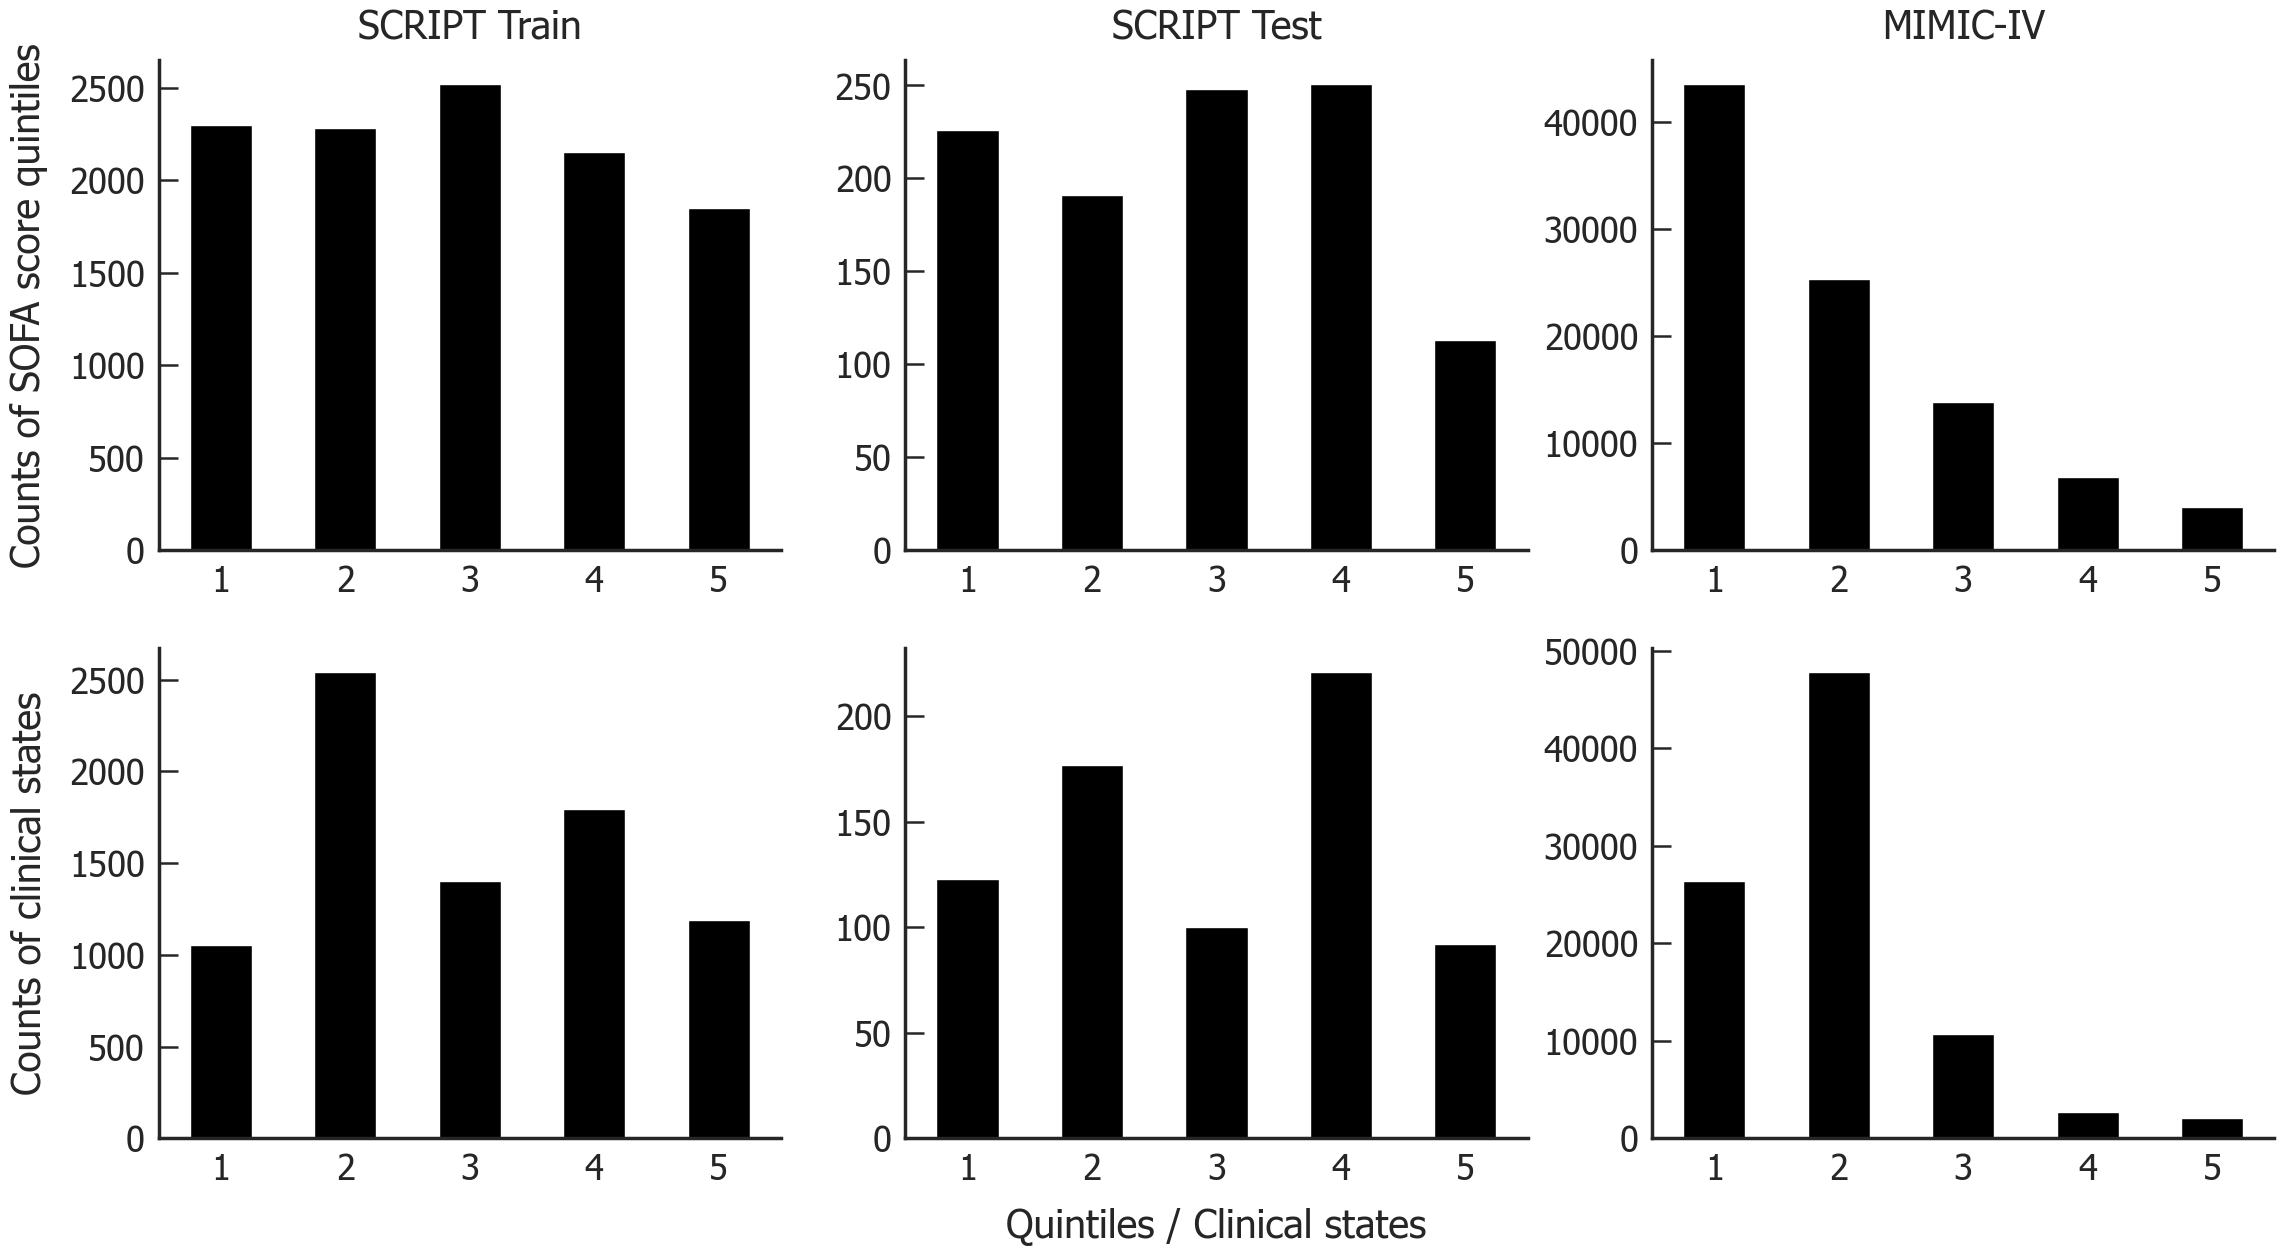

In [37]:
nc = 3
nr = 2
fig, axs = plt.subplots(nr, nc, figsize=plots.stdfigsize(nx=nc, ny=nr))

pd.cut(out_script_train['SOFA_score'], bins=np.percentile(out_script_train['SOFA_score'], [0,20,40,60,80,100]), include_lowest=True, right=True).value_counts().sort_index().plot(kind='bar', ax=axs[0,0], color='black')
pd.cut(out_script_test['SOFA_score'], bins=np.percentile(out_script_train['SOFA_score'], [0,20,40,60,80,100]), include_lowest=True, right=True).value_counts().sort_index().plot(kind='bar', ax=axs[0,1], color='black')
pd.cut(out_mimic_test['sofa_24hours'], bins=np.percentile(out_script_train['SOFA_score'], [0,20,40,60,80,100]), include_lowest=True, right=True).value_counts().sort_index().plot(kind='bar', ax=axs[0,2], color='black')

out_script_train['sofs+vtls_pred'].value_counts().sort_index().plot(kind='bar', ax=axs[1,0], color='black')
out_script_test['sofs+vtls_pred'].value_counts().sort_index().plot(kind='bar', ax=axs[1,1], color='black')
out_mimic_test['script_pred'].value_counts().sort_index().plot(kind='bar', ax=axs[1,2], color='black')

axs[0,0].set_title('SCRIPT Train')
axs[0,1].set_title('SCRIPT Test')
axs[0,2].set_title('MIMIC-IV')

for i in range(nr):
    for j in range(nc):
        # if i==0:
        #     axs[i,j].set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], rotation=0)
        # else:
        #     axs[i,j].set_xticklabels(axs[i,j].get_xticklabels(), rotation=0)
        axs[i,j].set_xticklabels(['1', '2', '3', '4', '5'], rotation=0)
        axs[i,j].set_xlabel('')
        axs[i,j].set_ylabel('')

        if i==0:
            axs[i,0].set_ylabel('Counts of SOFA score quintiles')
        else:
            axs[i,0].set_ylabel('Counts of clinical states')

        if j==1 and i==1:
            axs[i,j].set_xlabel('Quintiles / Clinical states')

In [38]:
out_script_train['sofa_binned'] = pd.cut(out_script_train['SOFA_score'], bins=np.percentile(out_script_train['SOFA_score'], [0,20,40,60,80,100]), include_lowest=True, right=True)
out_script_test['sofa_binned'] = pd.cut(out_script_test['SOFA_score'], bins=np.percentile(out_script_train['SOFA_score'], [0,20,40,60,80,100]), include_lowest=True, right=True)
out_mimic_test['sofa_binned'] = pd.cut(out_mimic_test['sofa_24hours'], bins=np.percentile(out_script_train['SOFA_score'], [0,20,40,60,80,100]), include_lowest=True, right=True)

In [39]:
out_script_train['days_to_discharge'] = np.where(
    out_script_train['ICU_stay'] == out_script_train['max_icu'],
    out_script_train['ICU_len'] - out_script_train['ICU_day'] + out_script_train['days_from_last_ICU_day_to_discharge'],
    np.nan
)

out_script_test['days_to_discharge'] = np.where(
    out_script_test['ICU_stay'] == out_script_test['max_icu'],
    out_script_test['ICU_len'] - out_script_test['ICU_day'] + out_script_test['days_from_last_ICU_day_to_discharge'],
    np.nan
)

out_mimic_test['days_to_discharge'] = np.where(
    out_mimic_test['Itv'].notna(),
    out_mimic_test['los_icu'] - out_mimic_test['icu_day'] + out_mimic_test['Itv'],
    np.nan
)

In [40]:
n_boot = 50
se = 9
mors = []
for cohort in ['script_train', 'script_test', 'mimic_test']:
    if cohort == 'script_train':
        data = out_script_train
    elif cohort == 'script_test':
        data = out_script_test
    elif cohort == 'mimic_test':
        data = out_mimic_test
    
    if cohort.startswith('script'):
        data_boot = data_bootstrap(data.set_index(['Patient_id', 'ICU_stay', 'ICU_day']), n_boot, se)
        for boot in range(n_boot):
            data_boot_ = data_boot[boot].reset_index()
            for ff in ['sofa_binned', 'sofs+vtls_pred']:
                for dd in [1,2,4,8,16,'all']:
                    f1 = data_boot_.Discharge_disposition=='Died'
                    f2 = data_boot_.days_to_discharge<dd if dd!='all' else data_boot_.days_to_discharge.notna()
                    f3 = data_boot_[ff].notna()
                    mor = data_boot_[f1&f2].groupby(ff, observed=False).size() / data_boot_.groupby(ff, observed=False).size()
                        
                    mors.append(pd.DataFrame({
                        'mortality': mor.values,
                        'cluster': mor.index if ff!='sofa_binned' else mor.index.rename_categories(['C1', 'C2', 'C3', 'C4', 'C5']),
                        'boot': boot, 
                        'cohort': cohort,
                        'feature': ff if ff=='sofa_binned' else 'states',
                        'days': dd
                    }))
                    
    else:
        data_boot = data_bootstrap(data.set_index(['subject_id', 'stay_id', 'icu_day']), n_boot, se)
        for boot in range(n_boot):
            data_boot_ = data_boot[boot].reset_index()
            for ff in ['sofa_binned', 'script_pred']:
                for dd in [1,2,4,8,16,'all']:
                    f1 = data_boot_.discharge=='Died'
                    f2 = pd.to_datetime(data_boot_['dischtime'])-pd.to_datetime(data_boot_['icu_date'])<pd.Timedelta(days=dd) if dd!='all' else data_boot_['Itv'].notna()
                    # f2 = (data_boot_['los_icu'] - data_boot_['icu_day'] + data_boot_['Itv'])<dd if dd!='all' else data_boot_['Itv'].notna()
                    f3 = data_boot_[ff].notna()
                    mor = data_boot_[f1&f2].groupby(ff, observed=False).size() / data_boot_.groupby(ff, observed=False).size()
                    mors.append(pd.DataFrame({
                        'mortality': mor.values,
                        'cluster': mor.index if ff!='sofa_binned' else mor.index.rename_categories(['C1', 'C2', 'C3', 'C4', 'C5']),
                        'boot': boot,
                        'cohort': cohort,
                        'feature': ff if ff=='sofa_binned' else 'states',
                        'days': dd
                    }))

mors = pd.concat(mors, ignore_index=True)

In [41]:
mors['mortality'] = mors['mortality']*100

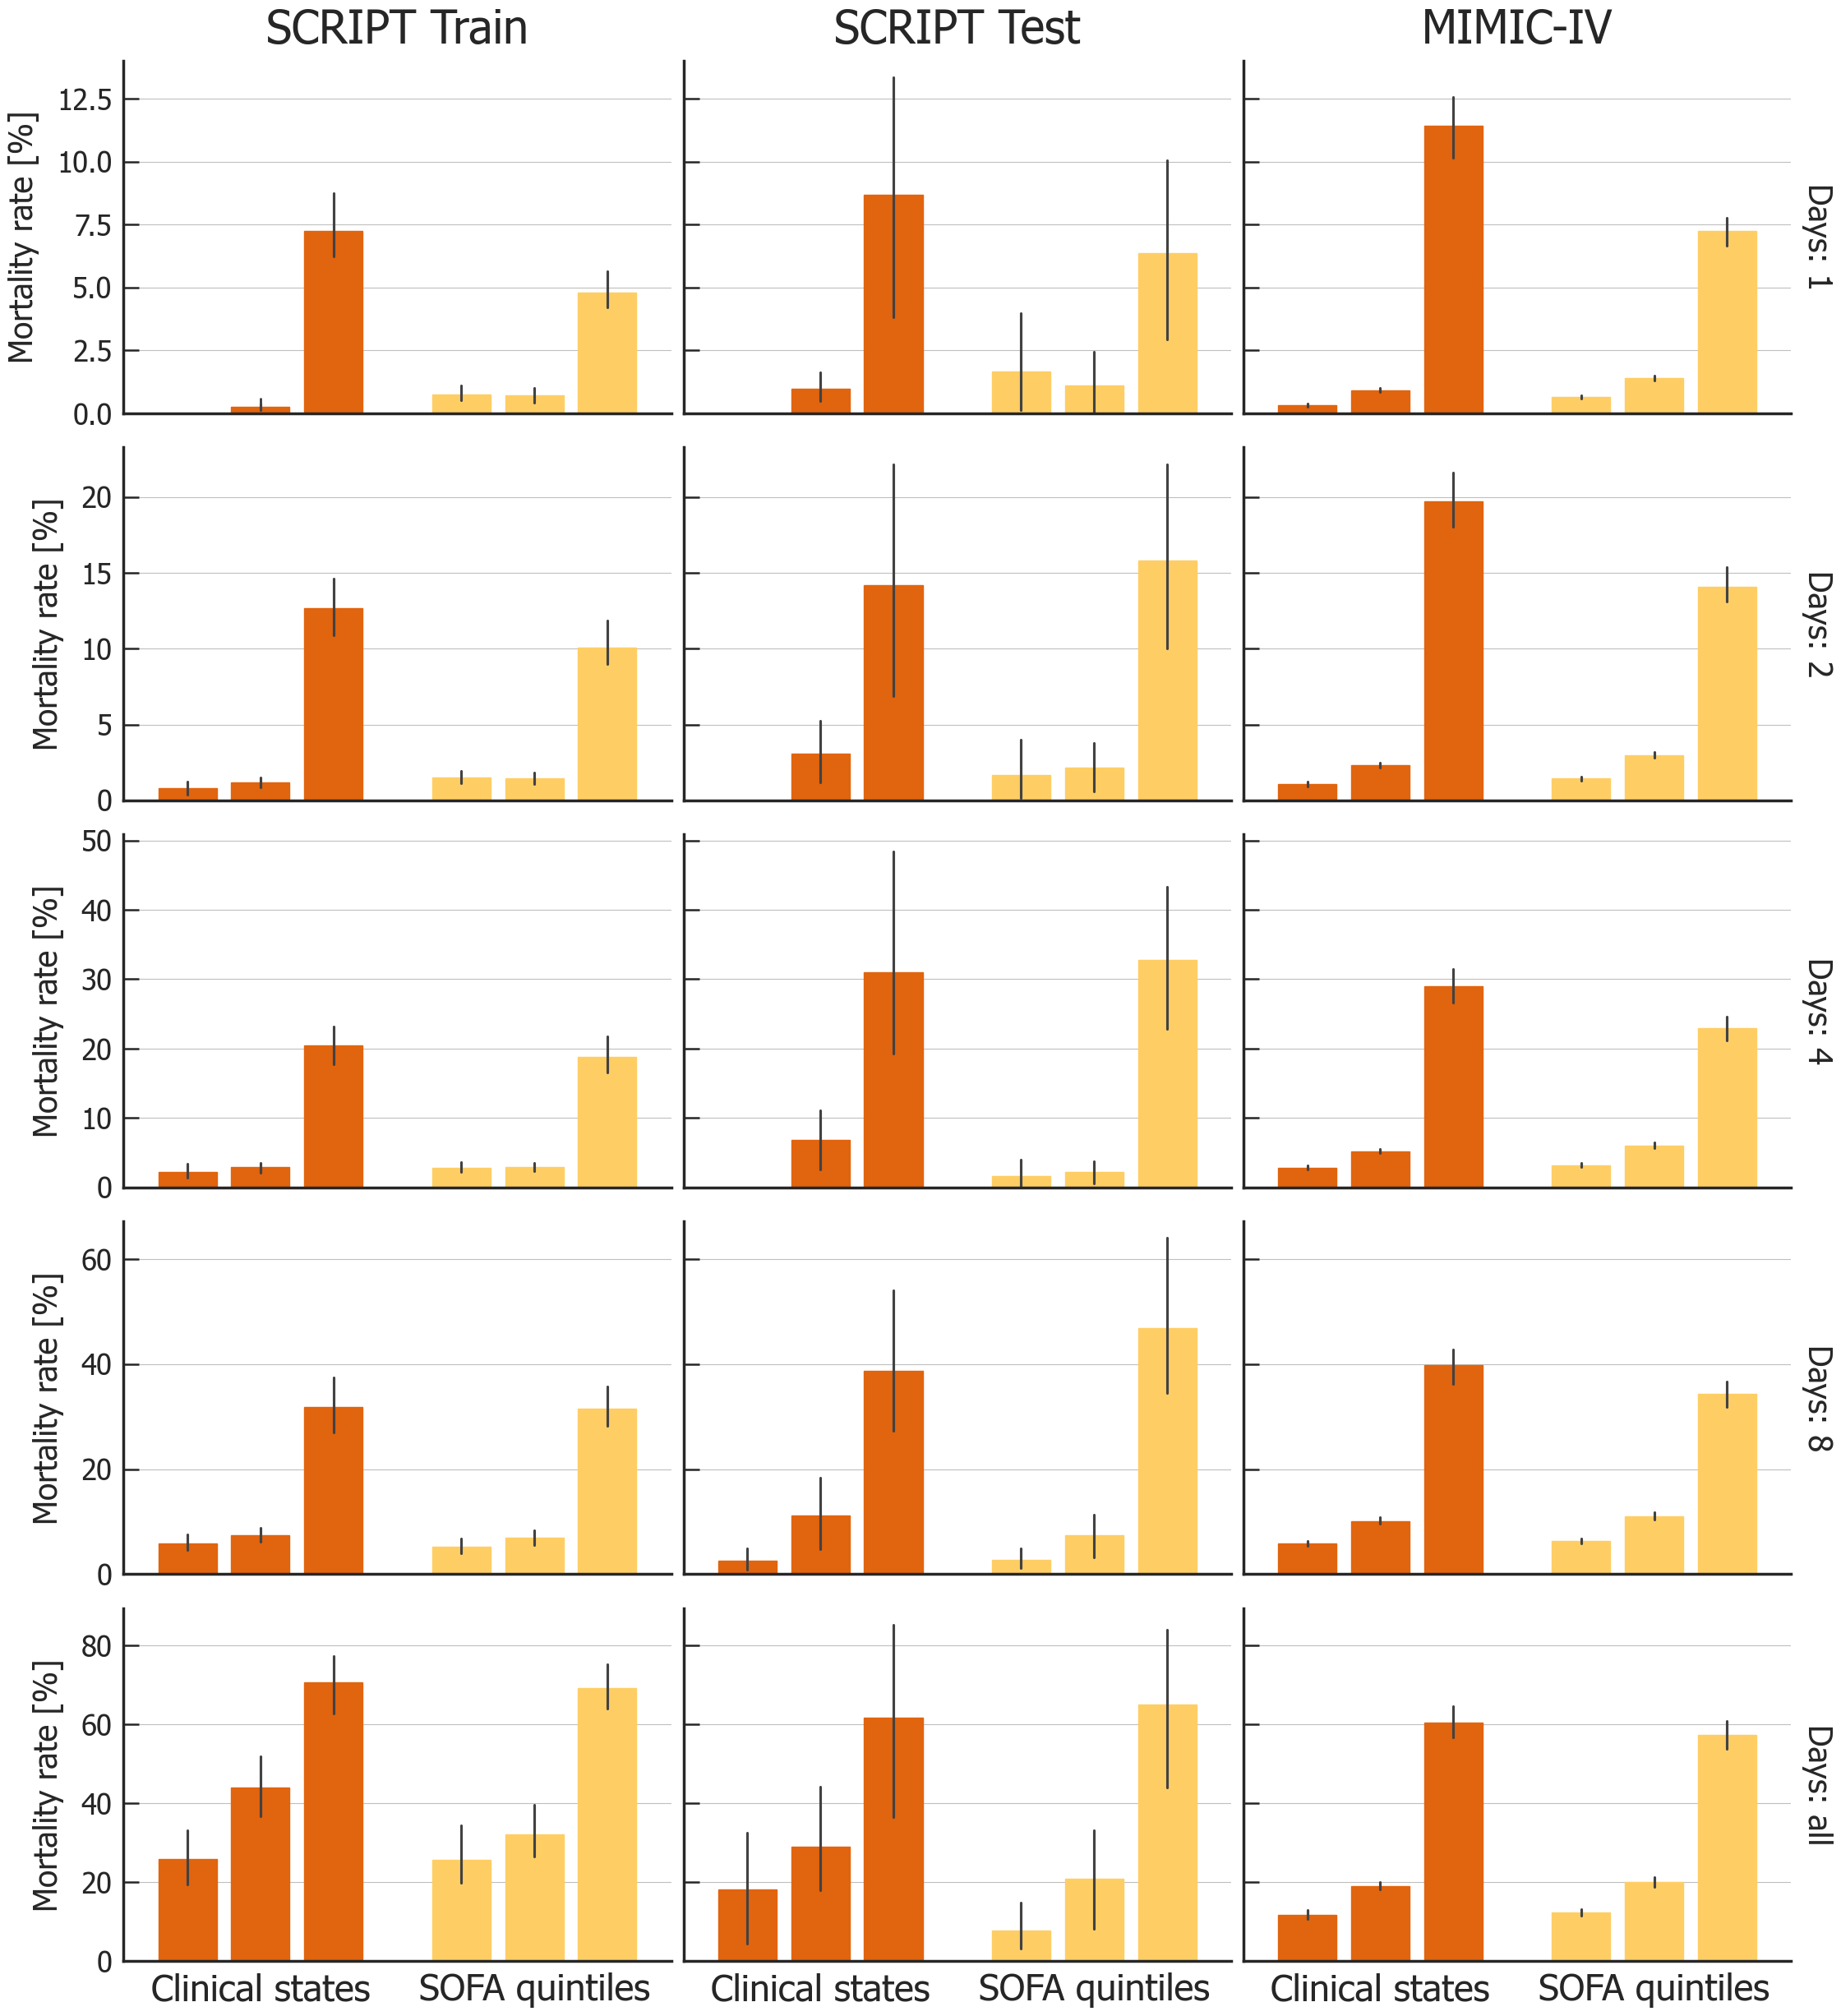

In [42]:
f1 = mors.cluster.isin(['C1', 'C2', 'C5'])
f2 = mors.days.isin([1,2,4,8,'all'])

g = sns.catplot(
    data=mors[f1&f2].reset_index(drop=True), hue='cluster', y='mortality', 
    x='feature', row='days', col='cohort', 
    kind='bar', sharey='row', #palette='YlOrBr',
    margin_titles=True, errorbar=('pi', 90), 
    order=['states', 'sofa_binned'], 
    aspect=1.5, height=5, gap=0.2, legend=False
)

g.set_titles(row_template='Days: {row_name}', col_template='{col_name}')
g.set_axis_labels('', 'Mortality rate [%]')
g.tick_params(axis='x', rotation=45)

for ax in g.axes.flat:
    # Customize the column title
    if ax.get_title().startswith("script_train"):
        ax.set_title('SCRIPT Train', fontsize=40)
    elif ax.get_title().startswith("script_test"):
        ax.set_title('SCRIPT Test', fontsize=40)
    elif ax.get_title().startswith("mimic_test"):
        ax.set_title('MIMIC-IV', fontsize=40)
    
    ax.grid(True, axis='y', c='Gray', alpha=.5)
    ax.xaxis.set_major_locator(ticker.FixedLocator(ax.get_xticks()))
    ax.set_xticklabels(['Clinical states', 'SOFA quintiles'], fontsize=32, rotation=0)

# sns.move_legend(g, "upper center", title='', labels=['1', '2', '5'], ncols=4, bbox_to_anchor=(0.5, 1.02), fontsize=32, title_fontsize=32)
g.axes[4,1].set_xlabel('')

for ax in g.axes.flat:
    for patch in ax.patches:
        if patch.get_x() < 0.5:  
            patch.set_color(sns.color_palette('YlOrBr', 2)[1])
        else:
            patch.set_color(sns.color_palette('YlOrBr', 2)[0])


In [43]:
results = []

# Iterate through each combination of feature and cohort
for feature in ['states', 'sofa_binned']:
    for cohort in mors['cohort'].unique():
        for day in mors['days'].unique():
            subset = mors[(mors['feature'] == feature) & (mors['cohort'] == cohort) & (mors['days'] == day)]
            subset = subset.fillna(0)
            
            # Calculate C2/C1 and C5/C2 ratios for each bootstrapping sample
            ratios_c2_c1 = subset.loc[subset['cluster'] == 'C2', 'mortality'].values / subset.loc[subset['cluster'] == 'C1', 'mortality'].values
            ratios_c5_c2 = subset.loc[subset['cluster'] == 'C5', 'mortality'].values / subset.loc[subset['cluster'] == 'C2', 'mortality'].values
            
            # Append the results
            results.append({
                'Feature': feature,
                'Cohort': cohort,
                'Days': day,
                'C2/C1 Mean (CI)': f'{np.nanmean(ratios_c2_c1, where=~np.isinf(ratios_c2_c1)):.2f} ({np.nanpercentile(ratios_c2_c1, 5):.2f} - {np.percentile(ratios_c2_c1, 95):.2f})',
                'C5/C2 Mean (CI)': f'{np.nanmean(ratios_c5_c2, where=~np.isinf(ratios_c5_c2)):.2f} ({np.nanpercentile(ratios_c5_c2, 5):.2f} - {np.percentile(ratios_c5_c2, 95):.2f})'
            })

# Convert the results to a DataFrame for better display
results_df = pd.DataFrame(results)

/var/folders/bq/h_mr2101559bvvsl7rpwj9y1fy1_l0/T/ipykernel_49243/3791092950.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  subset = subset.fillna(0)
/var/folders/bq/h_mr2101559bvvsl7rpwj9y1fy1_l0/T/ipykernel_49243/3791092950.py:11: RuntimeWarning: divide by zero encountered in divide
  ratios_c2_c1 = subset.loc[subset['cluster'] == 'C2', 'mortality'].values / subset.loc[subset['cluster'] == 'C1', 'mortality'].values
/var/folders/bq/h_mr2101559bvvsl7rpwj9y1fy1_l0/T/ipykernel_49243/3791092950.py:19: RuntimeWarning: Mean of empty slice
  'C2/C1 Mean (CI)': f'{np.nanmean(ratios_c2_c1, where=~np.isinf(ratios_c2_c1)):.2f} ({np.nanpercentile(ratios_c2_c1, 5):.2f} - {np.percentile(ratios_c2_c1, 95):.2f})',
/Users/fxx1047/src/clinical_states/.venv/lib/python3.9/site-package

In [44]:
results_df.set_index(['Cohort', 'Days', 'Feature']).unstack()

C2/C1 Mean (CI)                      \
Feature                    sofa_binned              states   
Cohort       Days                                            
mimic_test   1      2.16 (1.93 - 2.35)  2.87 (2.33 - 3.56)   
             2      2.06 (1.90 - 2.20)  2.18 (1.90 - 2.47)   
             4      1.88 (1.75 - 2.01)  1.84 (1.68 - 2.03)   
             8      1.76 (1.63 - 1.89)  1.76 (1.63 - 1.91)   
             16     1.69 (1.60 - 1.80)  1.69 (1.54 - 1.87)   
             all    1.63 (1.54 - 1.75)  1.63 (1.50 - 1.80)   
script_test  1       0.88 (0.00 - nan)     nan (nan - nan)   
             2       1.60 (0.35 - nan)     nan (nan - nan)   
             4       1.60 (0.35 - nan)     nan (nan - nan)   
             8      3.45 (1.05 - 6.71)   5.45 (1.79 - nan)   
             16    5.99 (1.24 - 11.82)  2.55 (0.92 - 5.72)   
             all    3.21 (1.13 - 5.96)  2.25 (1.11 - 6.59)   
script_train 1      1.02 (0.50 - 1.65)     nan (nan - nan)   
             2      1.01 (0.69 - 1.36)  1.69 (0.78 - 3.08)   
             4      1.09 (0.81 - 1.46)  1.45 (0.74 - 2.48)   
             8      1.34 (1.04 - 1.70)  1.28 (0.95 - 1.67)   
             16     1.34 (1.06 - 1.70)  1.32 (1.08 - 1.74)   
             all    1.26 (1.07 - 1.47)  1.73 (1.39 - 2.15)   

                        C5/C2 Mean (CI)                         
Feature                     sofa_binned                 states  
Cohort       Days                                               
mimic_test   1       5.20 (4.63 - 5.72)  12.44 (10.74 - 14.16)  
             2       4.74 (4.31 - 5.30)     8.49 (7.72 - 9.33)  
             4       3.82 (3.50 - 4.23)     5.58 (5.06 - 6.05)  
             8       3.12 (2.89 - 3.39)     3.93 (3.58 - 4.19)  
             16      2.93 (2.71 - 3.18)     3.32 (3.02 - 3.58)  
             all     2.86 (2.71 - 3.10)     3.18 (2.93 - 3.42)  
script_test  1        6.21 (2.19 - nan)     11.29 (3.29 - nan)  
             2      9.58 (3.97 - 23.77)    5.56 (2.15 - 11.40)  
             4     19.98 (8.82 - 53.36)    5.40 (2.68 - 11.16)  
             8      7.81 (3.82 - 14.64)     3.96 (2.08 - 7.18)  
             16      5.19 (2.16 - 9.52)     3.62 (2.00 - 6.34)  
             all     3.89 (1.77 - 6.46)     2.26 (1.34 - 3.70)  
script_train 1      7.04 (4.46 - 11.32)  31.47 (16.86 - 58.59)  
             2       7.06 (5.00 - 8.86)   11.29 (8.13 - 15.12)  
             4       6.59 (5.03 - 8.73)     7.11 (5.35 - 9.24)  
             8       4.63 (3.67 - 5.66)     4.38 (3.31 - 5.75)  
             16      3.64 (2.91 - 4.39)     3.11 (2.31 - 3.78)  
             all     2.18 (1.68 - 2.59)     1.63 (1.33 - 1.93)

# covid

In [45]:
n_boot = 50
se = 9
cvds = []
for cohort in ['script_train', 'script_test', 'mimic_test']:
    if cohort == 'script_train':
        data = out_script_train
    elif cohort == 'script_test':
        data = out_script_test
    elif cohort == 'mimic_test':
        data = out_mimic_test
    
    if cohort.startswith('script'):
        data_boot = data_bootstrap(data.set_index(['Patient_id', 'ICU_stay', 'ICU_day']), n_boot, se)
        for boot in range(n_boot):
            data_boot_ = data_boot[boot].reset_index()
            for ff in ['sofa_binned', 'sofs+vtls_pred']:
                for dd in ['All', 'Diagnoised episodes', 'Next day diagnosis']:
                    if dd=='All':
                        f1 = data_boot_.COVID_status
                        cvd = data_boot_[f1].groupby(ff, observed=False).size() / data_boot_.groupby(ff, observed=False).size()
                    elif dd=='Diagnoised episodes': 
                        f1 = data_boot_.COVID_status
                        f2 = data_boot_.Episode_etiology.isin(['Viral', 'Bacterial/viral'])
                        cvd = data_boot_[f1&f2].groupby(ff, observed=False).size() / data_boot_.groupby(ff, observed=False).size()
                    else:
                        f1 = data_boot_.COVID_status
                        f2 = (data_boot_.Episode_etiology.isna()) | (data_boot_.Episode_etiology.isin(['Bacterial', 'Culture-negative', 'Indeterminate']))
                        f3 = data_boot_.epi_etio_next_day.isin(['Viral', 'Bacterial/viral'])
                        cvd = data_boot_[f1&f2&f3].groupby(ff, observed=False).size() / data_boot_.groupby(ff, observed=False).size()
                    cvds.append(pd.DataFrame({
                        'cvd': cvd.values,
                        'cluster': cvd.index if ff!='sofa_binned' else cvd.index.rename_categories(['C1', 'C2', 'C3', 'C4', 'C5']),
                        'boot': boot, 
                        'cohort': cohort,
                        'feature': ff if ff=='sofa_binned' else 'states',
                        'days': dd
                    }))
        else:
            continue

cvds = pd.concat(cvds, ignore_index=True)

In [46]:
cvds['cvd'] = cvds['cvd']*100

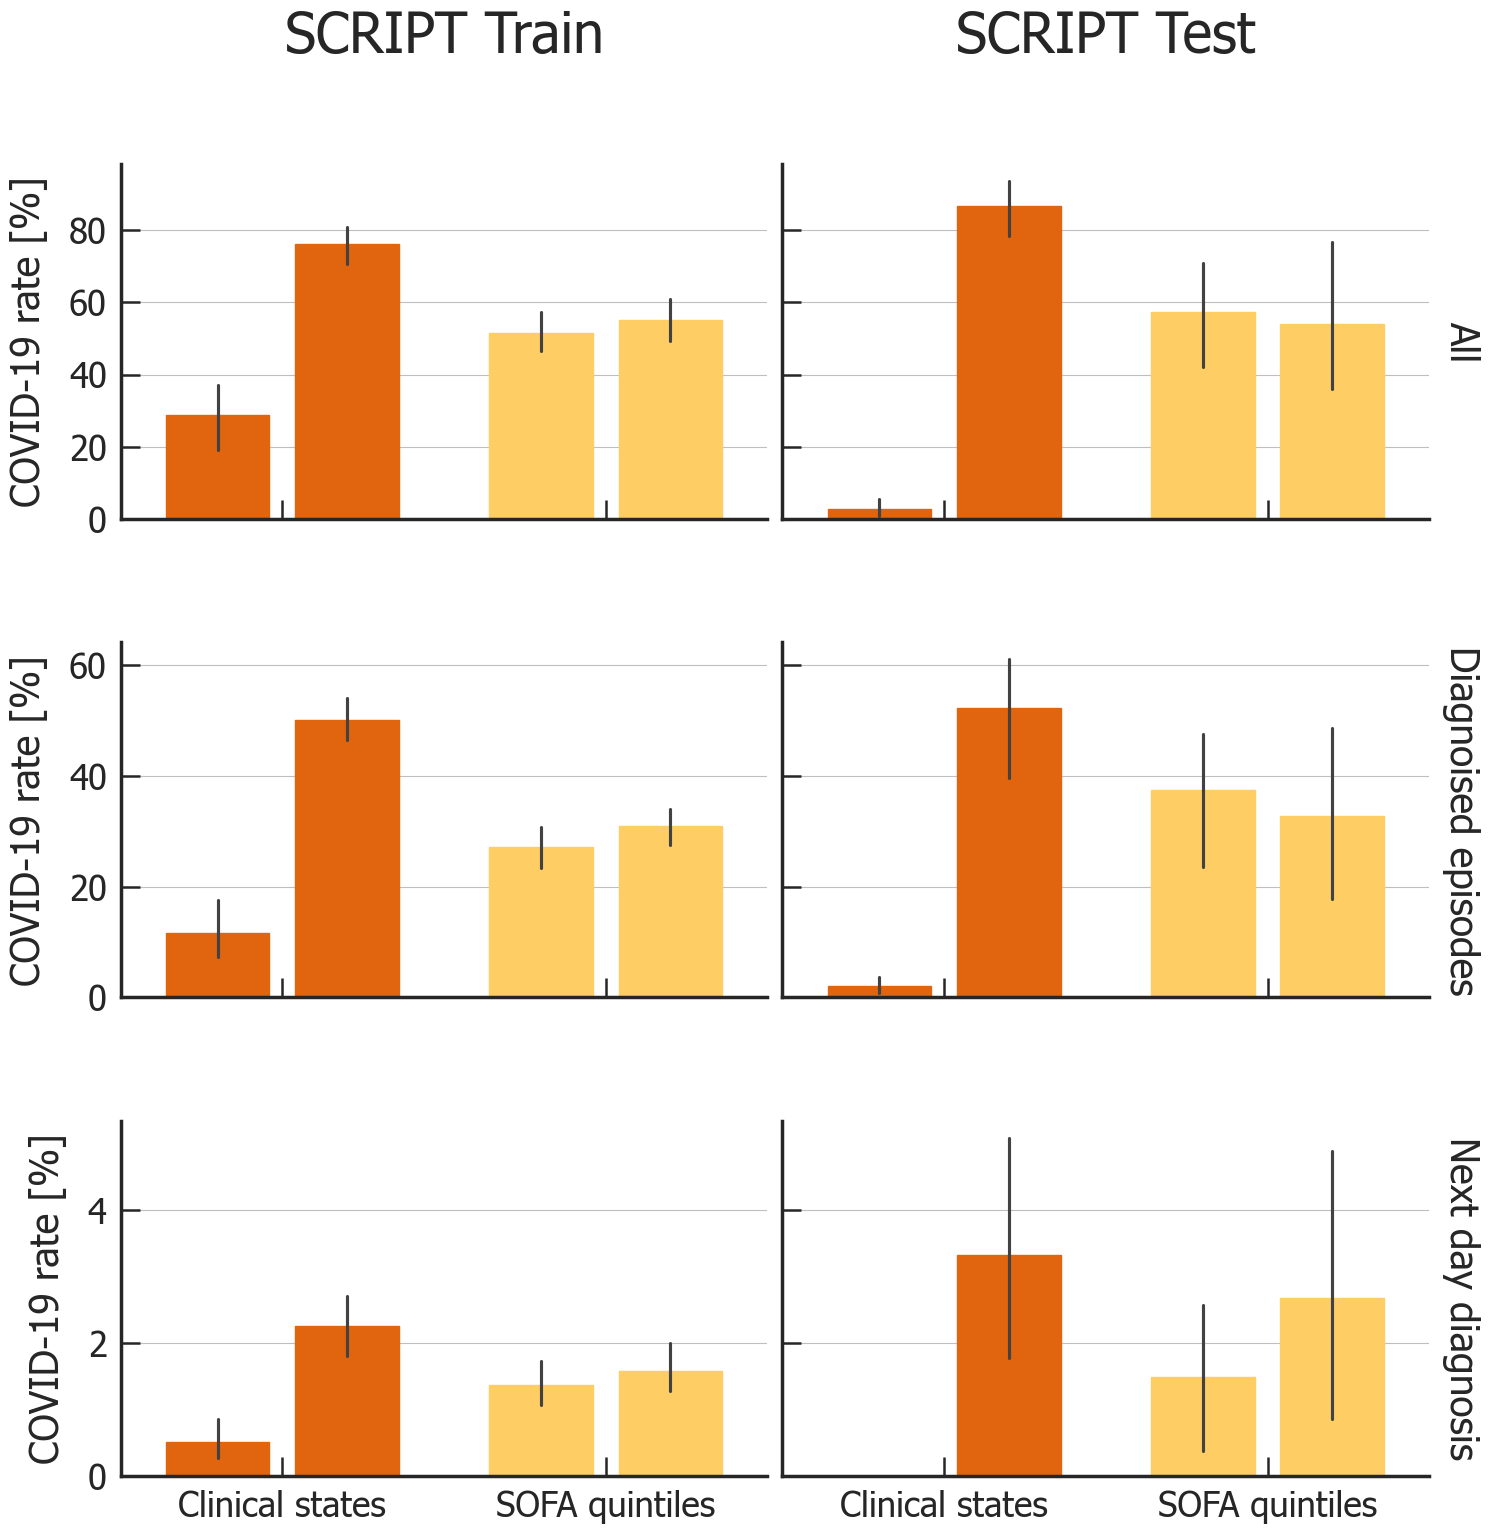

In [47]:
f1 = cvds.cluster.isin(['C3', 'C4'])
g = sns.catplot(data=cvds[f1], hue='cluster', y='cvd', x='feature', row='days', col='cohort', kind='bar', sharey='row', margin_titles=True, errorbar=('pi', 90), palette='YlOrBr', order=['states', 'sofa_binned'], aspect=1.5, height=5,gap=0.2, legend=False)

g.set_titles(row_template='{row_name}', col_template='{col_name}')
g.set_axis_labels('', 'COVID-19 rate [%]')
g.tick_params(axis='x', rotation=45)

for ax in g.axes.flat:
    # Customize the column title
    if ax.get_title().startswith("script_train"):
        ax.set_title('SCRIPT Train', fontsize=40, pad=80)
    elif ax.get_title().startswith("script_test"):
        ax.set_title('SCRIPT Test', fontsize=40, pad=80)
    elif ax.get_title().startswith("mimic_test"):
        ax.set_title('MIMIC', fontsize=40)

    ax.xaxis.set_major_locator(ticker.FixedLocator(ax.get_xticks()))
    ax.set_xticklabels(['Clinical states', 'SOFA quintiles'], rotation=0)
    ax.grid(True, axis='y', c='Gray', alpha=.5)

# sns.move_legend(g, "upper center", title='', labels=['3', '4'], ncol=2, bbox_to_anchor=(0.45, 1.02), fontsize=32)
g.axes[2,0].set_xlabel('', fontsize=32)
# plt.tight_layout()

for ax in g.axes.flat:
    for patch in ax.patches:
        if patch.get_x() < 0.5:  
            patch.set_color(sns.color_palette('YlOrBr', 2)[1])
        else:
            patch.set_color(sns.color_palette('YlOrBr', 2)[0])

In [48]:
results = []

# Iterate through each combination of feature and cohort
for feature in ['states', 'sofa_binned']:
    for cohort in cvds['cohort'].unique():
        for day in cvds['days'].unique():
            subset = cvds[(cvds['feature'] == feature) & (cvds['cohort'] == cohort) & (cvds['days'] == day)]
            subset = subset.fillna(0)
            
            # Calculate C2/C1 and C5/C2 ratios for each bootstrapping sample
            ratios_c4_c3 = subset.loc[subset['cluster'] == 'C4', 'cvd'].values / subset.loc[subset['cluster'] == 'C3', 'cvd'].values
            
            # Append the results
            results.append({
                'Feature': feature,
                'Cohort': cohort,
                'Days': day,
                'C4/C3 Mean (CI)': f'{np.nanmean(ratios_c4_c3, where=~np.isinf(ratios_c4_c3)):.2f} ({np.nanpercentile(ratios_c4_c3, 5):.2f} - {np.percentile(ratios_c4_c3, 95):.2f})'
            })

# Convert the results to a DataFrame for better display
results_df = pd.DataFrame(results)

/var/folders/bq/h_mr2101559bvvsl7rpwj9y1fy1_l0/T/ipykernel_49243/360319603.py:11: RuntimeWarning: divide by zero encountered in divide
  ratios_c4_c3 = subset.loc[subset['cluster'] == 'C4', 'cvd'].values / subset.loc[subset['cluster'] == 'C3', 'cvd'].values
/Users/fxx1047/src/clinical_states/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/var/folders/bq/h_mr2101559bvvsl7rpwj9y1fy1_l0/T/ipykernel_49243/360319603.py:11: RuntimeWarning: invalid value encountered in divide
  ratios_c4_c3 = subset.loc[subset['cluster'] == 'C4', 'cvd'].values / subset.loc[subset['cluster'] == 'C3', 'cvd'].values
/var/folders/bq/h_mr2101559bvvsl7rpwj9y1fy1_l0/T/ipykernel_49243/360319603.py:18: RuntimeWarning: Mean of empty slice
  'C4/C3 Mean (CI)': f'{np.nanmean(ratios_c4_c3, where=~np.isinf(ratios_c4_c3)):.2f} ({np.nanpercentile(ratios_c4_c3, 5):.2f} - {np.percentile(ratios_c4_c3, 95):.2f})'


In [49]:
results_df.set_index(['Cohort', 'Days', 'Feature']).unstack()

C4/C3 Mean (CI)                        
Feature                                   sofa_binned                  states
Cohort       Days                                                            
script_test  All                   0.95 (0.63 - 1.23)  43.86 (15.72 - 110.10)
             Diagnoised episodes   0.89 (0.53 - 1.33)     32.86 (13.83 - nan)
             Next day diagnosis   2.44 (0.74 - 10.59)         nan (nan - nan)
script_train All                   1.07 (0.98 - 1.19)      2.75 (1.97 - 3.95)
             Diagnoised episodes   1.14 (1.02 - 1.30)      4.57 (2.97 - 7.01)
             Next day diagnosis    1.18 (0.80 - 1.63)      4.94 (2.57 - 8.48)

# transition

In [50]:
out_script_train['pros'] = out_script_train.ICU_day/out_script_train.ICU_len 
out_script_train.loc[out_script_train.ICU_stay!=out_script_train.max_icu, 'pros'] = np.nan
out_script_train['cpros'] = pd.cut(out_script_train['pros'], bins=np.linspace(0,1,6), include_lowest=True, labels=np.arange(1,6))

In [51]:
out_script_test['pros'] = out_script_test.ICU_day/out_script_test.ICU_len
out_script_test['cpros'] = pd.cut(out_script_test['pros'], bins=np.linspace(0,1,3), include_lowest=True, labels=np.arange(1,3))

In [52]:
out_script_test['discharge'] = 'Other'
out_script_test.loc[out_script_test['Discharge_disposition']=='Died', 'discharge'] = 'Died'
out_script_test.loc[out_script_test['Discharge_disposition']=='Home', 'discharge'] = 'Recovered'

In [53]:
out_script_train['discharge'] = 'Other'
out_script_train.loc[out_script_train['Discharge_disposition']=='Died', 'discharge'] = 'Died'
out_script_train.loc[out_script_train['Discharge_disposition']=='Home', 'discharge'] = 'Recovered'

In [54]:
out_script_train['days_to_discharge_binned'] = np.where(
    out_script_train['days_to_discharge'] < 6, '< 6 days',
    np.where(
        out_script_train['days_to_discharge'] < 13, '6-13 days',
        np.where(
            out_script_train['days_to_discharge'] < 21, '13-21 days',
            np.where(
                out_script_train['days_to_discharge'] < 36, '21-36 days',
                '>= 36 days'
            )
        )
    )
)

In [55]:
out_script_train.days_to_discharge_binned = out_script_train.days_to_discharge_binned.astype('category').cat.reorder_categories(['>= 36 days', '21-36 days', '13-21 days', '6-13 days', '< 6 days'], ordered=True)

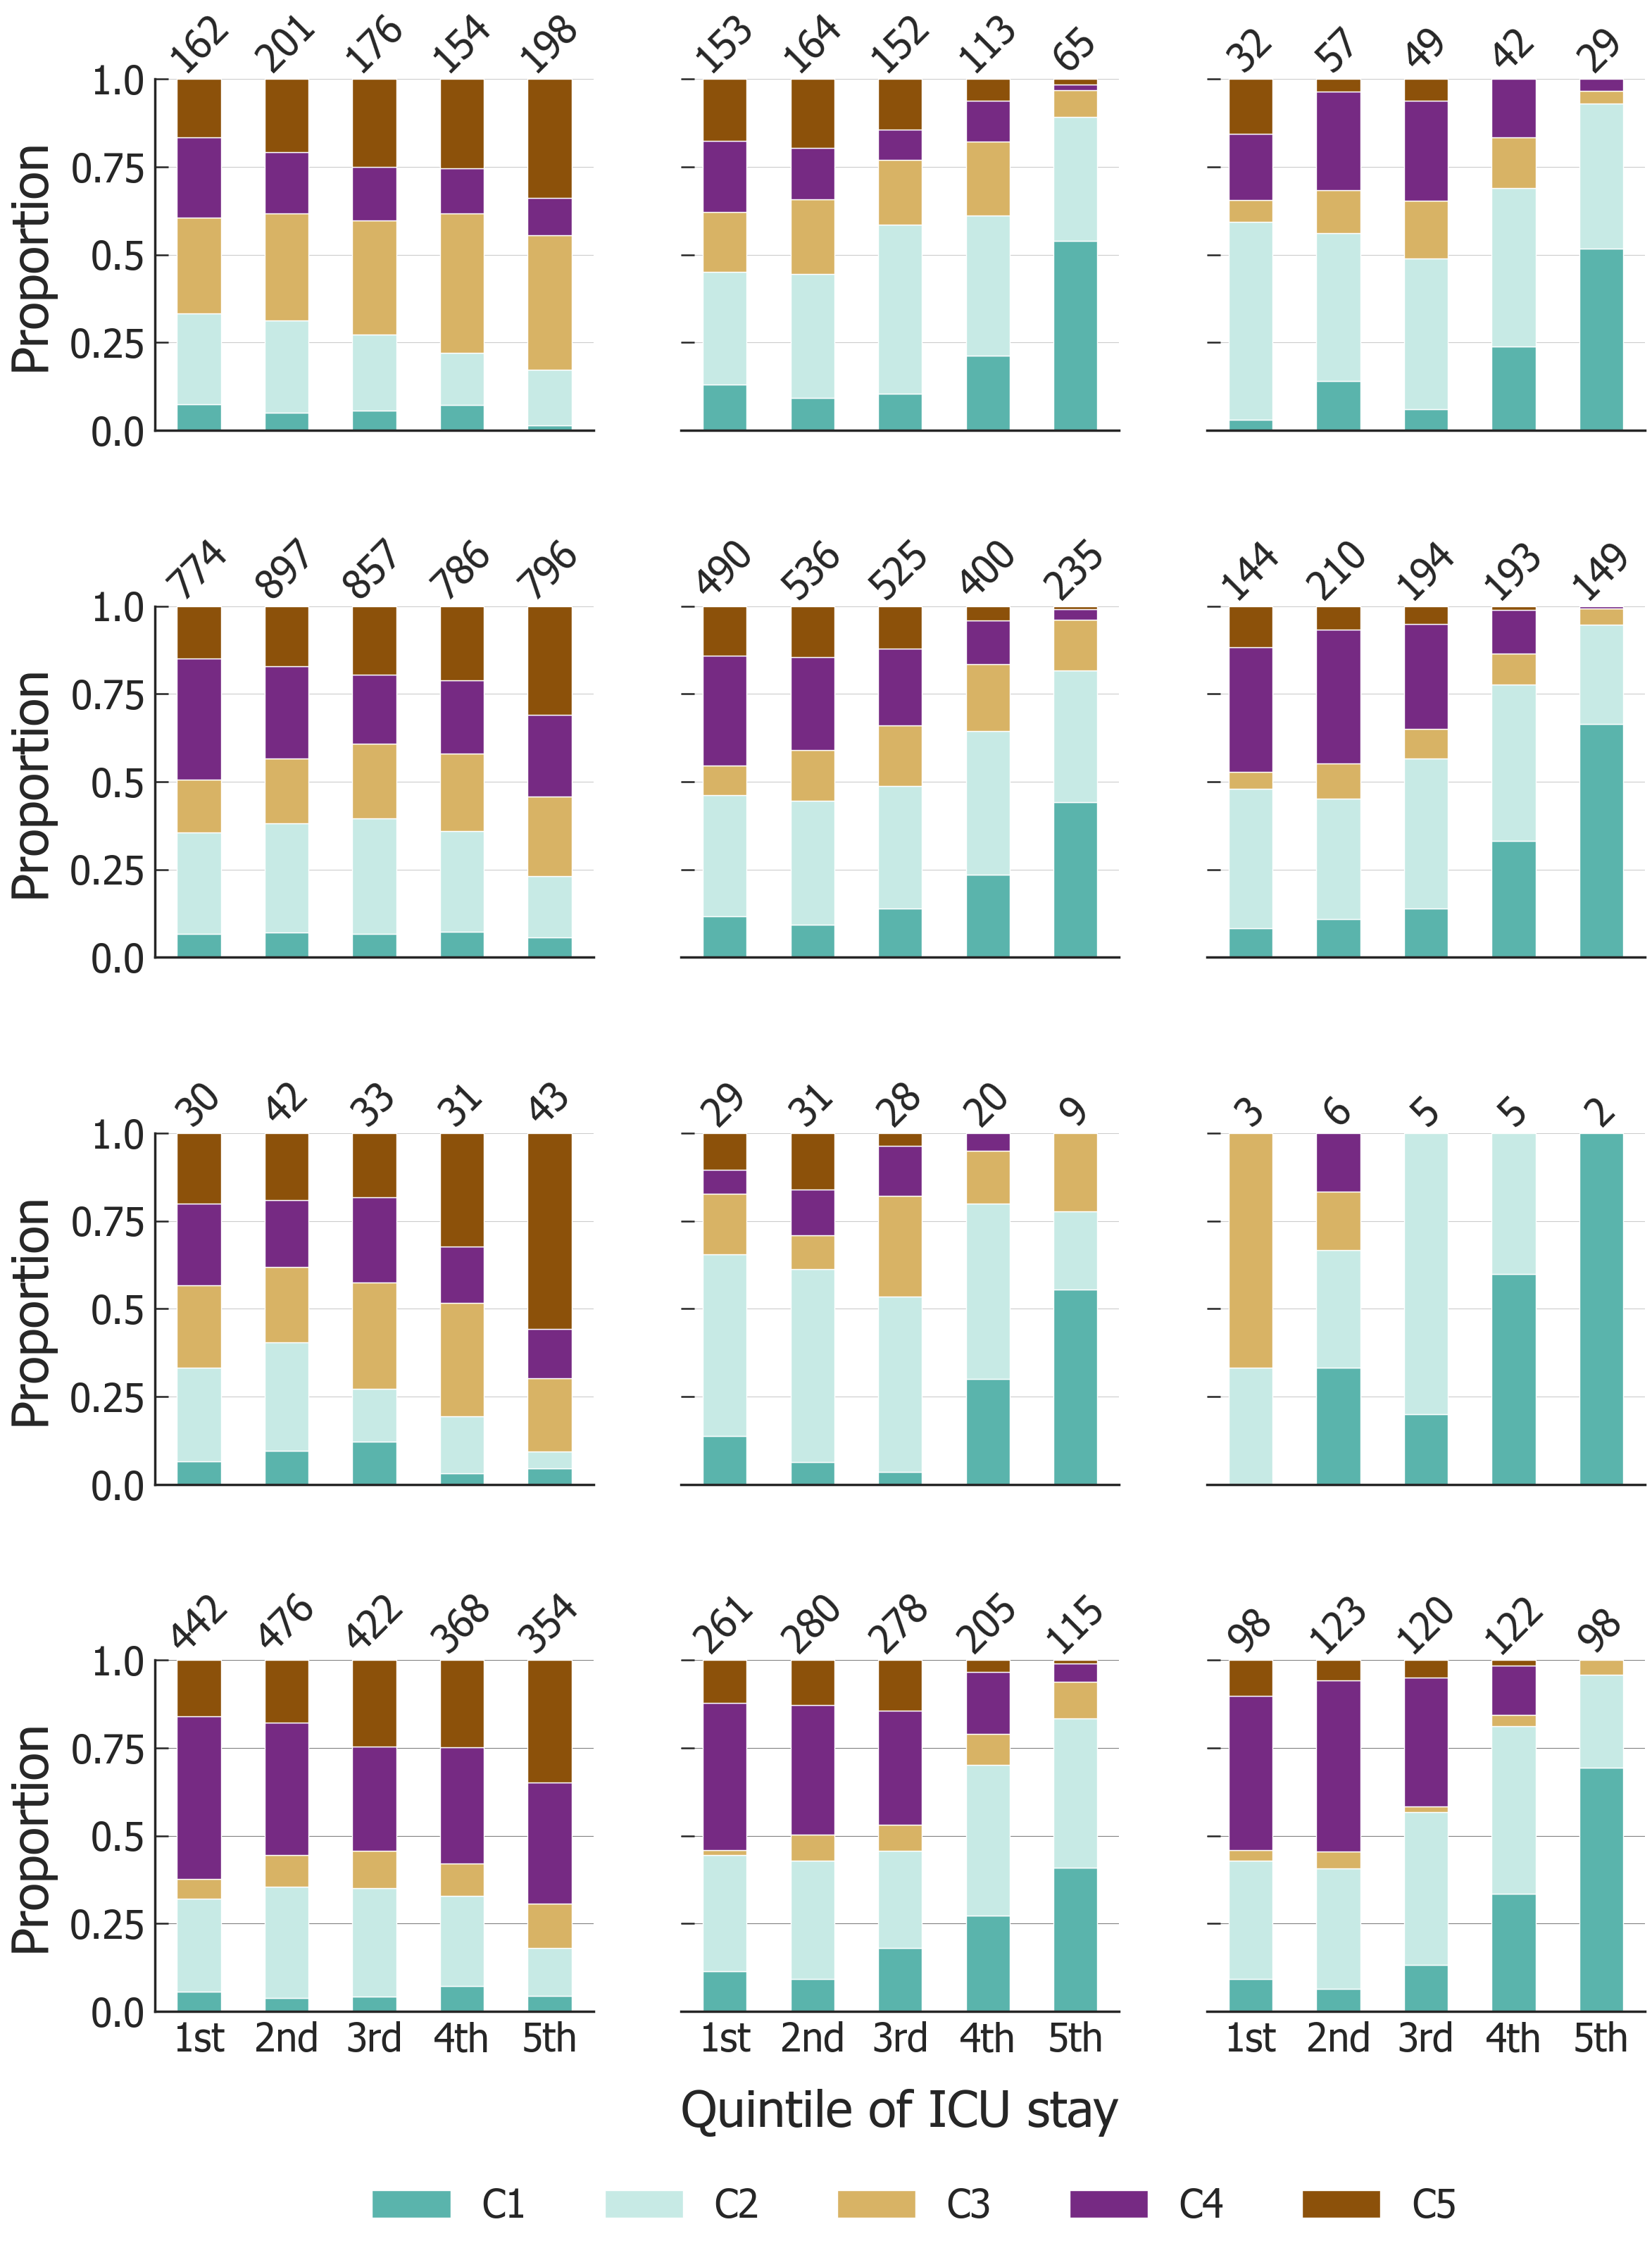

In [56]:
nc = 3
nr = 4
fig, axs = plt.subplots(nr, nc, figsize=plots.stdfigsize(nx=nc, ny=nr))

f1 = out_script_train.Patient_category=='Other Pneumonia'
f2 = out_script_train.Episode_etiology!='Bacterial/viral'
df = out_script_train[f1&f2].groupby(['cpros', 'discharge'], observed=False)['sofs+vtls_pred'].value_counts(normalize=True).unstack()
df1 = out_script_train[f1&f2].groupby(['cpros', 'discharge'], observed=False)['sofs+vtls_pred'].value_counts().unstack()

for i in range(3):
    df.xs(['Died', 'Other', 'Recovered'][i], level='discharge').plot(
        kind='bar', stacked=True, ax=axs[0,i], legend=False, rot=0,
        color={'C1': '#5ab4ac', 'C2': '#c7eae5', 'C3': '#d8b365', 'C4': '#762a83', 'C5': '#8c510a'}
    )
    axs[0,i].set_xlabel('')
    # axs[0,i].set_title(['Died', 'Other', 'Recovered'][i], fontdict={'fontsize':32})
    axs[0,0].set_ylabel('Proportion', fontsize=52)
    axs[0,i].grid(axis='y') 
    axs[0,i].set_ylim(0,1) 
    axs[0,i].set_yticks(np.arange(0,1.01,0.25))
    axs[0,i].set_yticklabels(np.arange(0,1.01,0.25), fontsize=40)
    
    if i!=0:
        axs[0,i].get_yaxis().set_visible(True)
        axs[0,i].spines['left'].set_visible(False)
        axs[0,i].set_yticks(np.arange(0,1.01,0.25))
        axs[0,i].set_yticklabels(['', '', '', '', ''], fontsize=40)
        
    axs[0,i].set_xticklabels([], fontsize=40)
    # axs[0,1].legend(['D', 'v', 'nv', 'S'], bbox_to_anchor=(0, 1), frameon=False, ncol=4, fontsize=30)

    for ip, p in enumerate(axs[0,i].patches):
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        if (ip//5 == 4):
            ann = df1.xs(['Died', 'Other', 'Recovered'][i], level='discharge').sum(axis=1).values[ip%5]
            axs[0,i].text(x+width/2, 1, 
                        '{:n}'.format(ann), 
                        horizontalalignment='center', verticalalignment='bottom', 
                        fontsize=40, rotation=45)
            
df = out_script_train.groupby(['cpros', 'discharge'], observed=False)['sofs+vtls_pred'].value_counts(normalize=True).unstack()
df1 = out_script_train.groupby(['cpros', 'discharge'], observed=False)['sofs+vtls_pred'].value_counts().unstack()

for i in range(3):
    df.xs(['Died', 'Other', 'Recovered'][i], level='discharge').plot(
        kind='bar', stacked=True, ax=axs[1,i], legend=False, rot=0, 
        color={'C1': '#5ab4ac', 'C2': '#c7eae5', 'C3': '#d8b365', 'C4': '#762a83', 'C5': '#8c510a'}
    )
    axs[1,i].set_xlabel('')
    # axs[0,i].set_title(['Died', 'Other', 'Recovered'][i], fontdict={'fontsize':32})
    axs[1,0].set_ylabel('Proportion', fontsize=52)
    axs[1,i].grid(axis='y') 
    axs[1,i].set_ylim(0,1) 
    axs[1,i].set_yticks(np.arange(0,1.01,0.25))
    axs[1,i].set_yticklabels(np.arange(0,1.01,0.25), fontsize=40)
    
    if i!=0:
        axs[1,i].get_yaxis().set_visible(True)
        axs[1,i].set_ylabel('')
        axs[1,i].spines['left'].set_visible(False)
        axs[1,i].set_yticks(np.arange(0,1.01,0.25))
        axs[1,i].set_yticklabels(['', '', '', '', ''])
        
    axs[1,i].set_xticklabels([], fontsize=40)
    for ip, p in enumerate(axs[1,i].patches):
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        if (ip//5 == 4):
            ann = df1.xs(['Died', 'Other', 'Recovered'][i], level='discharge').sum(axis=1).values[ip%5]
            axs[1,i].text(x+width/2, 1, 
                        '{:n}'.format(ann), 
                        horizontalalignment='center', verticalalignment='bottom', 
                        fontsize=40, rotation=45)

f1 = out_script_train.Patient_category.isin(['Other Viral Pneumonia'])
f2 = out_script_train.Episode_etiology!='Bacterial'
df = out_script_train[f1&f2].groupby(['cpros', 'discharge'], observed=False)['sofs+vtls_pred'].value_counts(normalize=True).unstack()
df1 = out_script_train[f1&f2].groupby(['cpros', 'discharge'], observed=False)['sofs+vtls_pred'].value_counts().unstack()

for i in range(3):
    df.xs(['Died', 'Other', 'Recovered'][i], level='discharge').plot(
        kind='bar', stacked=True, ax=axs[2,i], legend=False, rot=0, 
        color={'C1': '#5ab4ac', 'C2': '#c7eae5', 'C3': '#d8b365', 'C4': '#762a83', 'C5': '#8c510a'}
    )
    axs[2,i].set_xlabel('')
    # axs[0,i].set_title(['Died', 'Other', 'Recovered'][i], fontdict={'fontsize':32})
    axs[2,0].set_ylabel('Proportion', fontsize=52)
    axs[2,i].grid(axis='y') 
    axs[2,i].set_ylim(0,1) 
    axs[2,i].set_yticks(np.arange(0,1.01,0.25))
    axs[2,i].set_yticklabels(np.arange(0,1.01,0.25), fontsize=40)
    
    if i!=0:
        axs[2,i].get_yaxis().set_visible(True)
        axs[2,i].set_ylabel('')
        axs[2,i].spines['left'].set_visible(False)
        axs[2,i].set_yticks(np.arange(0,1.01,0.25))
        axs[2,i].set_yticklabels(['', '', '', '', ''])
        
    axs[2,i].set_xticklabels([], fontsize=40)
    for ip, p in enumerate(axs[2,i].patches):
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        if (ip//5 == 4):
            ann = df1.xs(['Died', 'Other', 'Recovered'][i], level='discharge').sum(axis=1).values[ip%5]
            axs[2,i].text(x+width/2, 1, 
                        '{:n}'.format(ann), 
                        horizontalalignment='center', verticalalignment='bottom', 
                        fontsize=40, rotation=45)
            
f1 = out_script_train.Patient_category=='COVID-19'
f2 = out_script_train.Episode_etiology!='Bacterial'
df = out_script_train[f1&f2].groupby(['cpros', 'discharge'], observed=False)['sofs+vtls_pred'].value_counts(normalize=True).unstack()
df1 = out_script_train[f1&f2].groupby(['cpros', 'discharge'], observed=False)['sofs+vtls_pred'].value_counts().unstack()

for i in range(3):
    df.xs(['Died', 'Other', 'Recovered'][i], level='discharge').plot(
        kind='bar', stacked=True, ax=axs[3,i], legend=False, rot=0, 
        color={'C1': '#5ab4ac', 'C2': '#c7eae5', 'C3': '#d8b365', 'C4': '#762a83', 'C5': '#8c510a'}
    )
    if i==1:
        axs[3,i].set_xlabel('Quintile of ICU stay', fontsize=52, labelpad=30)
    else:
        axs[3,i].set_xlabel('')
    
    axs[3,0].set_ylabel('Proportion', fontsize=52)
    axs[3,i].grid(axis='y', c='Gray') 
    axs[3,i].set_ylim(0,1)
    axs[3,i].set_yticks(np.arange(0,1.01,0.25))
    axs[3,i].set_yticklabels(np.arange(0,1.01,0.25), fontsize=40)
    
    if i!=0:
        axs[3,i].get_yaxis().set_visible(True)
        axs[3,i].spines['left'].set_visible(False)
        axs[3,i].set_yticks(np.arange(0,1.01,0.25))
        axs[3,i].set_yticklabels(['', '', '', '', ''])
        
    axs[3,i].set_xticklabels(['1st', '2nd', '3rd', '4th', '5th'], fontsize=40)
    for ip, p in enumerate(axs[3,i].patches):
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        if (ip//5 == 4):
            ann = df1.xs(['Died', 'Other', 'Recovered'][i], level='discharge').sum(axis=1).values[ip%5]
            axs[3,i].text(x+width/2, 1, 
                        '{:n}'.format(ann), 
                        horizontalalignment='center', verticalalignment='bottom', 
                        fontsize=40, rotation=45)
axs[3,1].legend(['C1', 'C2', 'C3', 'C4', 'C5'], bbox_to_anchor=(1.85,-.4), frameon=False, ncol=5, fontsize=40)
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=.5, wspace=0.2)

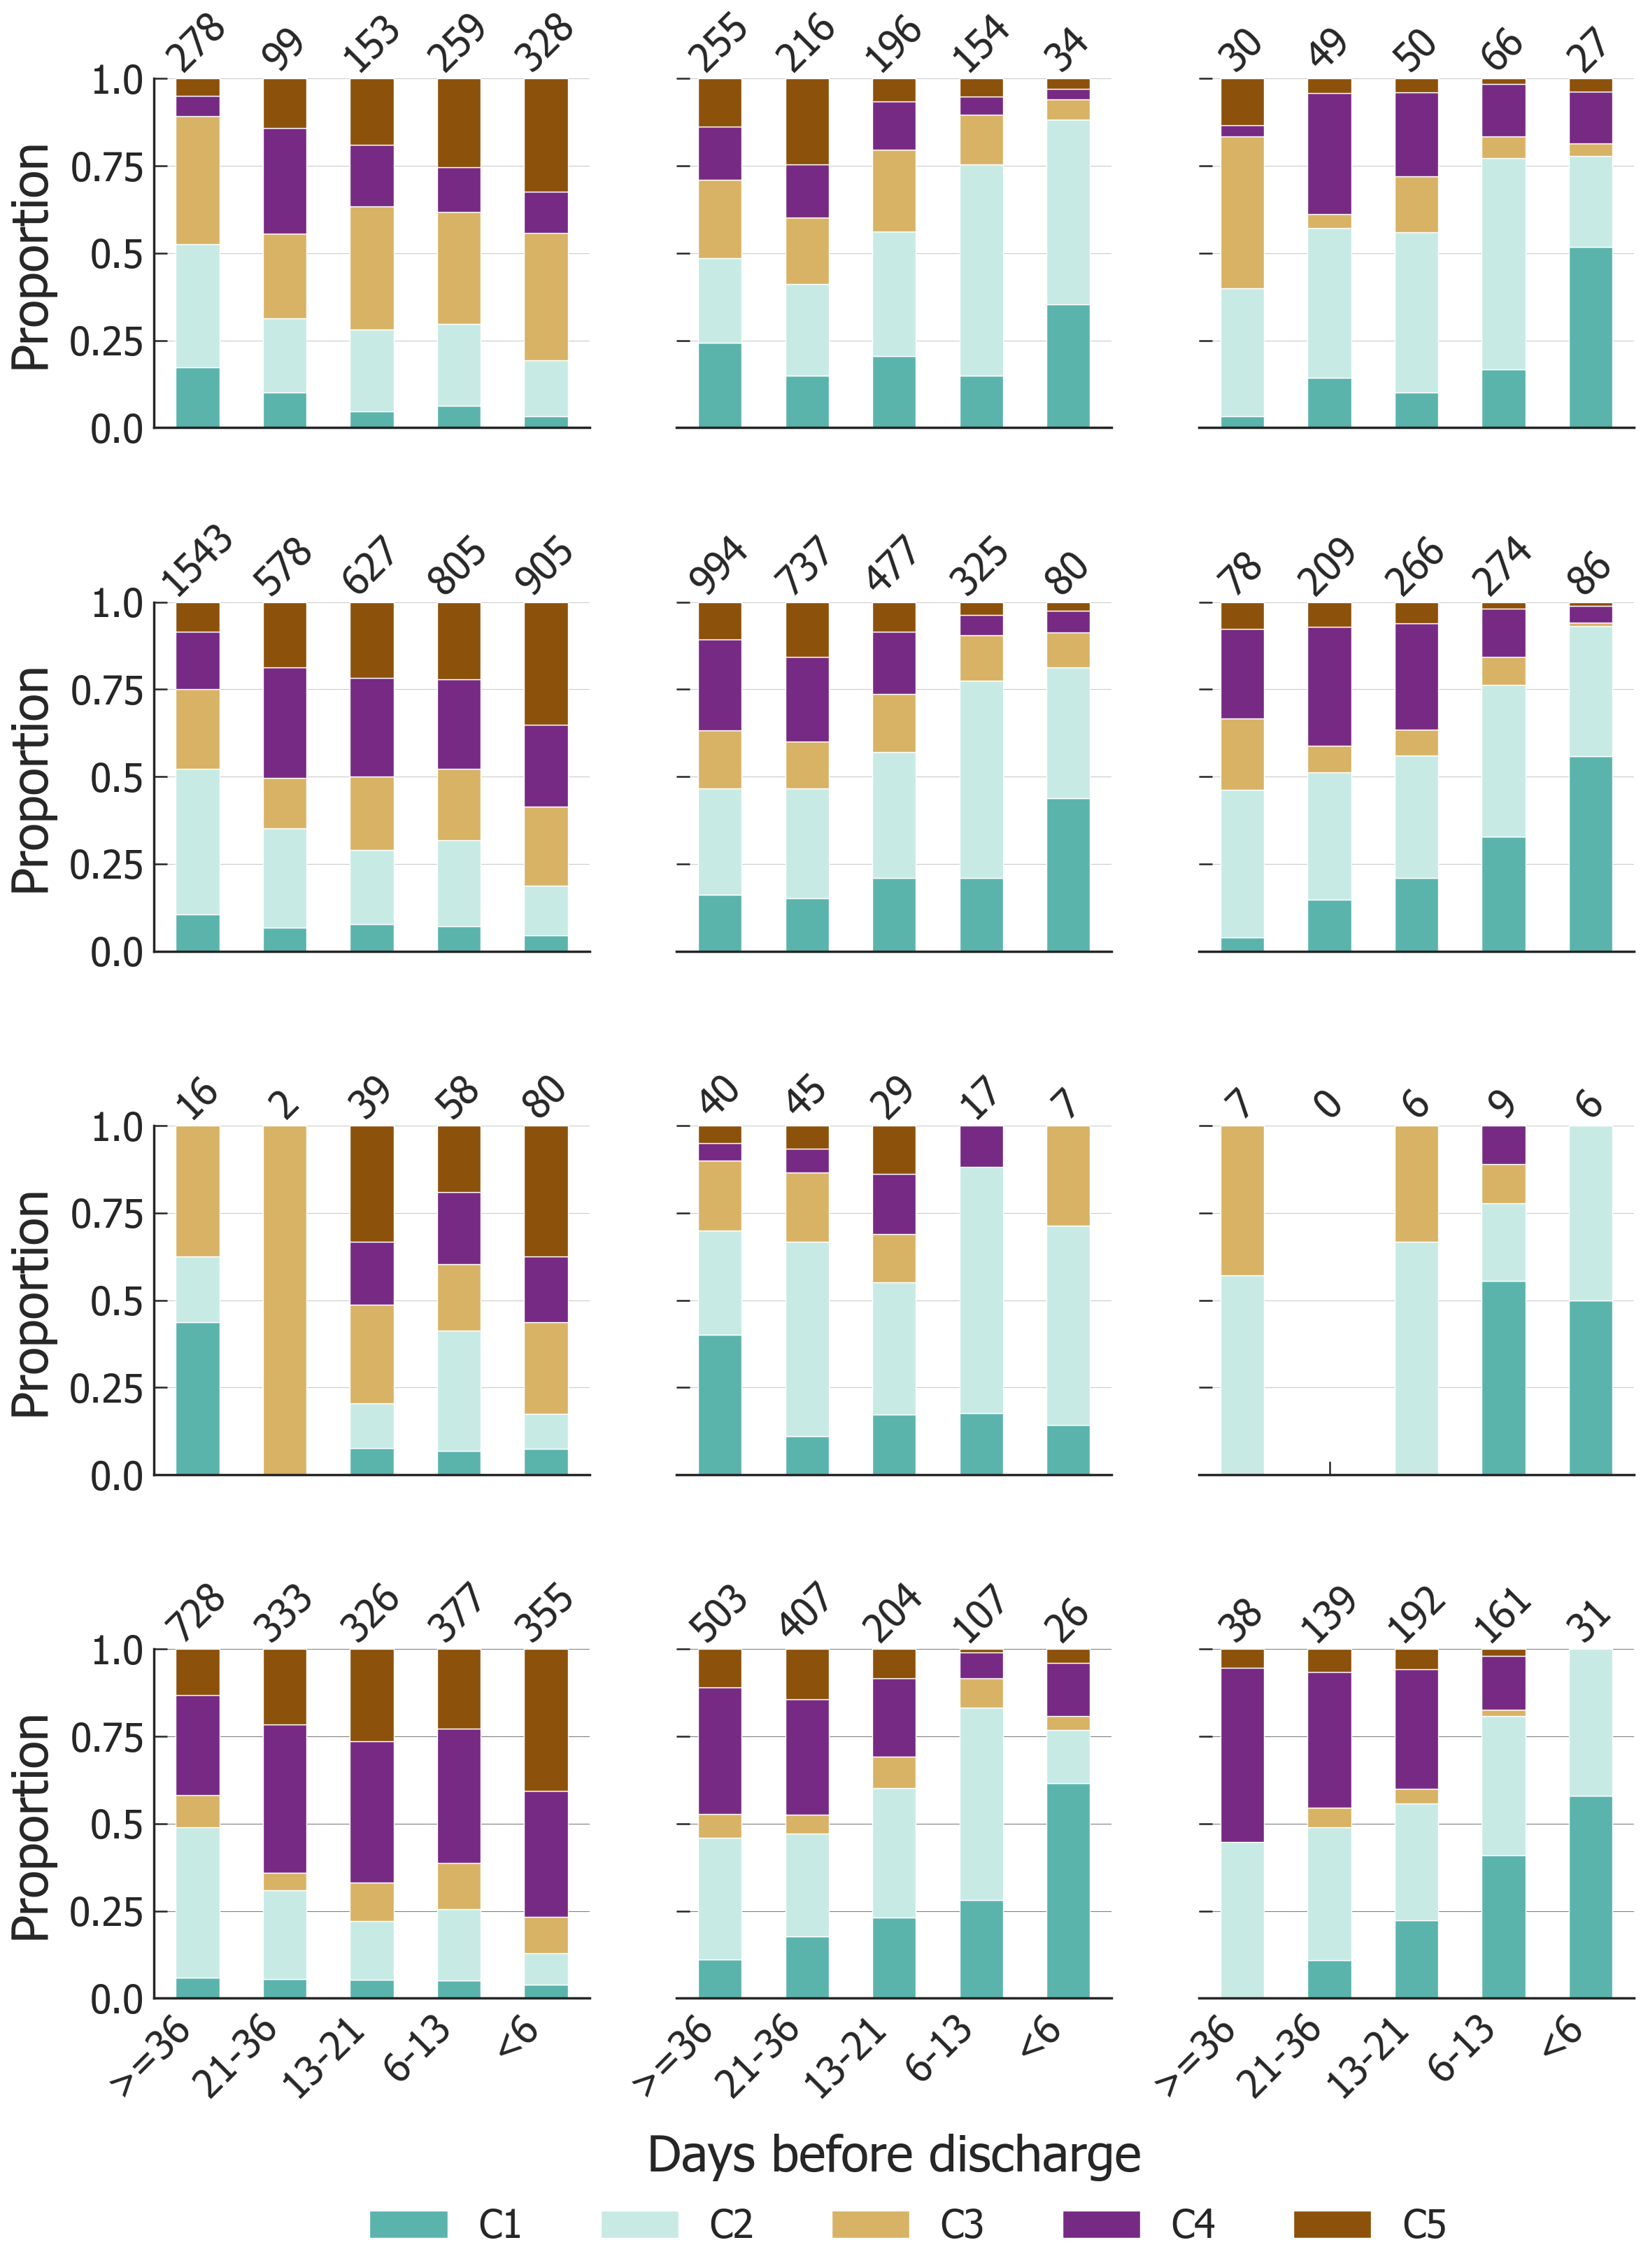

In [57]:
nc = 3
nr = 4
fig, axs = plt.subplots(nr, nc, figsize=plots.stdfigsize(nx=nc, ny=nr))

f1 = out_script_train.Patient_category=='Other Pneumonia'
f2 = out_script_train.Episode_etiology!='Bacterial/viral'
df = out_script_train[f1&f2].groupby(['days_to_discharge_binned', 'discharge'], observed=False)['sofs+vtls_pred'].value_counts(normalize=True).unstack()
df1 = out_script_train[f1&f2].groupby(['days_to_discharge_binned', 'discharge'], observed=False)['sofs+vtls_pred'].value_counts().unstack()

for i in range(3):
    df.xs(['Died', 'Other', 'Recovered'][i], level='discharge').plot(
        kind='bar', stacked=True, ax=axs[0,i], legend=False, rot=0,
        color={'C1': '#5ab4ac', 'C2': '#c7eae5', 'C3': '#d8b365', 'C4': '#762a83', 'C5': '#8c510a'}
    )
    axs[0,i].set_xlabel('')
    # axs[0,i].set_title(['Died', 'Other', 'Recovered'][i], fontdict={'fontsize':32})
    axs[0,0].set_ylabel('Proportion', fontsize=52)
    axs[0,i].grid(axis='y') 
    axs[0,i].set_ylim(0,1) 
    axs[0,i].set_yticks(np.arange(0,1.01,0.25))
    axs[0,i].set_yticklabels(np.arange(0,1.01,0.25), fontsize=40)
    
    if i!=0:
        axs[0,i].get_yaxis().set_visible(True)
        axs[0,i].spines['left'].set_visible(False)
        axs[0,i].set_yticks(np.arange(0,1.01,0.25))
        axs[0,i].set_yticklabels(['', '', '', '', ''], fontsize=40)
        
    axs[0,i].set_xticklabels([], fontsize=40)
    # axs[0,1].legend(['D', 'v', 'nv', 'S'], bbox_to_anchor=(0, 1), frameon=False, ncol=4, fontsize=30)

    for ip, p in enumerate(axs[0,i].patches):
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        if (ip//5 == 4):
            ann = df1.xs(['Died', 'Other', 'Recovered'][i], level='discharge').sum(axis=1).values[ip%5]
            axs[0,i].text(x+width/2, 1, 
                        '{:n}'.format(ann), 
                        horizontalalignment='center', verticalalignment='bottom', 
                        fontsize=40, rotation=45)
            
df = out_script_train.groupby(['days_to_discharge_binned', 'discharge'], observed=False)['sofs+vtls_pred'].value_counts(normalize=True).unstack()
df1 = out_script_train.groupby(['days_to_discharge_binned', 'discharge'], observed=False)['sofs+vtls_pred'].value_counts().unstack()

for i in range(3):
    df.xs(['Died', 'Other', 'Recovered'][i], level='discharge').plot(
        kind='bar', stacked=True, ax=axs[1,i], legend=False, rot=0, 
        color={'C1': '#5ab4ac', 'C2': '#c7eae5', 'C3': '#d8b365', 'C4': '#762a83', 'C5': '#8c510a'}
    )
    axs[1,i].set_xlabel('')
    # axs[0,i].set_title(['Died', 'Other', 'Recovered'][i], fontdict={'fontsize':32})
    axs[1,0].set_ylabel('Proportion', fontsize=52)
    axs[1,i].grid(axis='y') 
    axs[1,i].set_ylim(0,1) 
    axs[1,i].set_yticks(np.arange(0,1.01,0.25))
    axs[1,i].set_yticklabels(np.arange(0,1.01,0.25), fontsize=40)
    
    if i!=0:
        axs[1,i].get_yaxis().set_visible(True)
        axs[1,i].set_ylabel('')
        axs[1,i].spines['left'].set_visible(False)
        axs[1,i].set_yticks(np.arange(0,1.01,0.25))
        axs[1,i].set_yticklabels(['', '', '', '', ''])
        
    axs[1,i].set_xticklabels([], fontsize=40)
    for ip, p in enumerate(axs[1,i].patches):
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        if (ip//5 == 4):
            ann = df1.xs(['Died', 'Other', 'Recovered'][i], level='discharge').sum(axis=1).values[ip%5]
            axs[1,i].text(x+width/2, 1, 
                        '{:n}'.format(ann), 
                        horizontalalignment='center', verticalalignment='bottom', 
                        fontsize=40, rotation=45)

f1 = out_script_train.Patient_category.isin(['Other Viral Pneumonia'])
f2 = out_script_train.Episode_etiology!='Bacterial'
df = out_script_train[f1&f2].groupby(['days_to_discharge_binned', 'discharge'], observed=False)['sofs+vtls_pred'].value_counts(normalize=True).unstack()
df1 = out_script_train[f1&f2].groupby(['days_to_discharge_binned', 'discharge'], observed=False)['sofs+vtls_pred'].value_counts().unstack()

for i in range(3):
    df.xs(['Died', 'Other', 'Recovered'][i], level='discharge').plot(
        kind='bar', stacked=True, ax=axs[2,i], legend=False, rot=0, 
        color={'C1': '#5ab4ac', 'C2': '#c7eae5', 'C3': '#d8b365', 'C4': '#762a83', 'C5': '#8c510a'}
    )
    axs[2,i].set_xlabel('')
    # axs[0,i].set_title(['Died', 'Other', 'Recovered'][i], fontdict={'fontsize':32})
    axs[2,0].set_ylabel('Proportion', fontsize=52)
    axs[2,i].grid(axis='y') 
    axs[2,i].set_ylim(0,1) 
    axs[2,i].set_yticks(np.arange(0,1.01,0.25))
    axs[2,i].set_yticklabels(np.arange(0,1.01,0.25), fontsize=40)
    
    if i!=0:
        axs[2,i].get_yaxis().set_visible(True)
        axs[2,i].set_ylabel('')
        axs[2,i].spines['left'].set_visible(False)
        axs[2,i].set_yticks(np.arange(0,1.01,0.25))
        axs[2,i].set_yticklabels(['', '', '', '', ''])
        
    axs[2,i].set_xticklabels([], fontsize=40)
    for ip, p in enumerate(axs[2,i].patches):
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        if (ip//5 == 4):
            ann = df1.xs(['Died', 'Other', 'Recovered'][i], level='discharge').sum(axis=1).values[ip%5]
            axs[2,i].text(x+width/2, 1, 
                        '{:n}'.format(ann), 
                        horizontalalignment='center', verticalalignment='bottom', 
                        fontsize=40, rotation=45)
            
f1 = out_script_train.Patient_category=='COVID-19'
f2 = out_script_train.Episode_etiology!='Bacterial'
df = out_script_train[f1&f2].groupby(['days_to_discharge_binned', 'discharge'], observed=False)['sofs+vtls_pred'].value_counts(normalize=True).unstack()
df1 = out_script_train[f1&f2].groupby(['days_to_discharge_binned', 'discharge'], observed=False)['sofs+vtls_pred'].value_counts().unstack()

for i in range(3):
    df.xs(['Died', 'Other', 'Recovered'][i], level='discharge').plot(
        kind='bar', stacked=True, ax=axs[3,i], legend=False, rot=0, 
        color={'C1': '#5ab4ac', 'C2': '#c7eae5', 'C3': '#d8b365', 'C4': '#762a83', 'C5': '#8c510a'}
    )
    if i==1:
        axs[3,i].set_xlabel('Days before discharge', fontsize=52, labelpad=30)
    else:
        axs[3,i].set_xlabel('')
    
    axs[3,0].set_ylabel('Proportion', fontsize=52)
    axs[3,i].grid(axis='y', c='Gray') 
    axs[3,i].set_ylim(0,1)
    axs[3,i].set_yticks(np.arange(0,1.01,0.25))
    axs[3,i].set_yticklabels(np.arange(0,1.01,0.25), fontsize=40)
    
    if i!=0:
        axs[3,i].get_yaxis().set_visible(True)
        axs[3,i].spines['left'].set_visible(False)
        axs[3,i].set_yticks(np.arange(0,1.01,0.25))
        axs[3,i].set_yticklabels(['', '', '', '', ''])
        
    axs[3,i].set_xticklabels(['>=36', '21-36', '13-21', '6-13', '<6'], fontsize=40, rotation=45, ha='right')
    for ip, p in enumerate(axs[3,i].patches):
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        if (ip//5 == 4):
            ann = df1.xs(['Died', 'Other', 'Recovered'][i], level='discharge').sum(axis=1).values[ip%5]
            axs[3,i].text(x+width/2, 1, 
                        '{:n}'.format(ann), 
                        horizontalalignment='center', verticalalignment='bottom', 
                        fontsize=40, rotation=45)
axs[3,1].legend(['C1', 'C2', 'C3', 'C4', 'C5'], bbox_to_anchor=(1.85,-.5), frameon=False, ncol=5, fontsize=40)
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=.5, wspace=0.2)

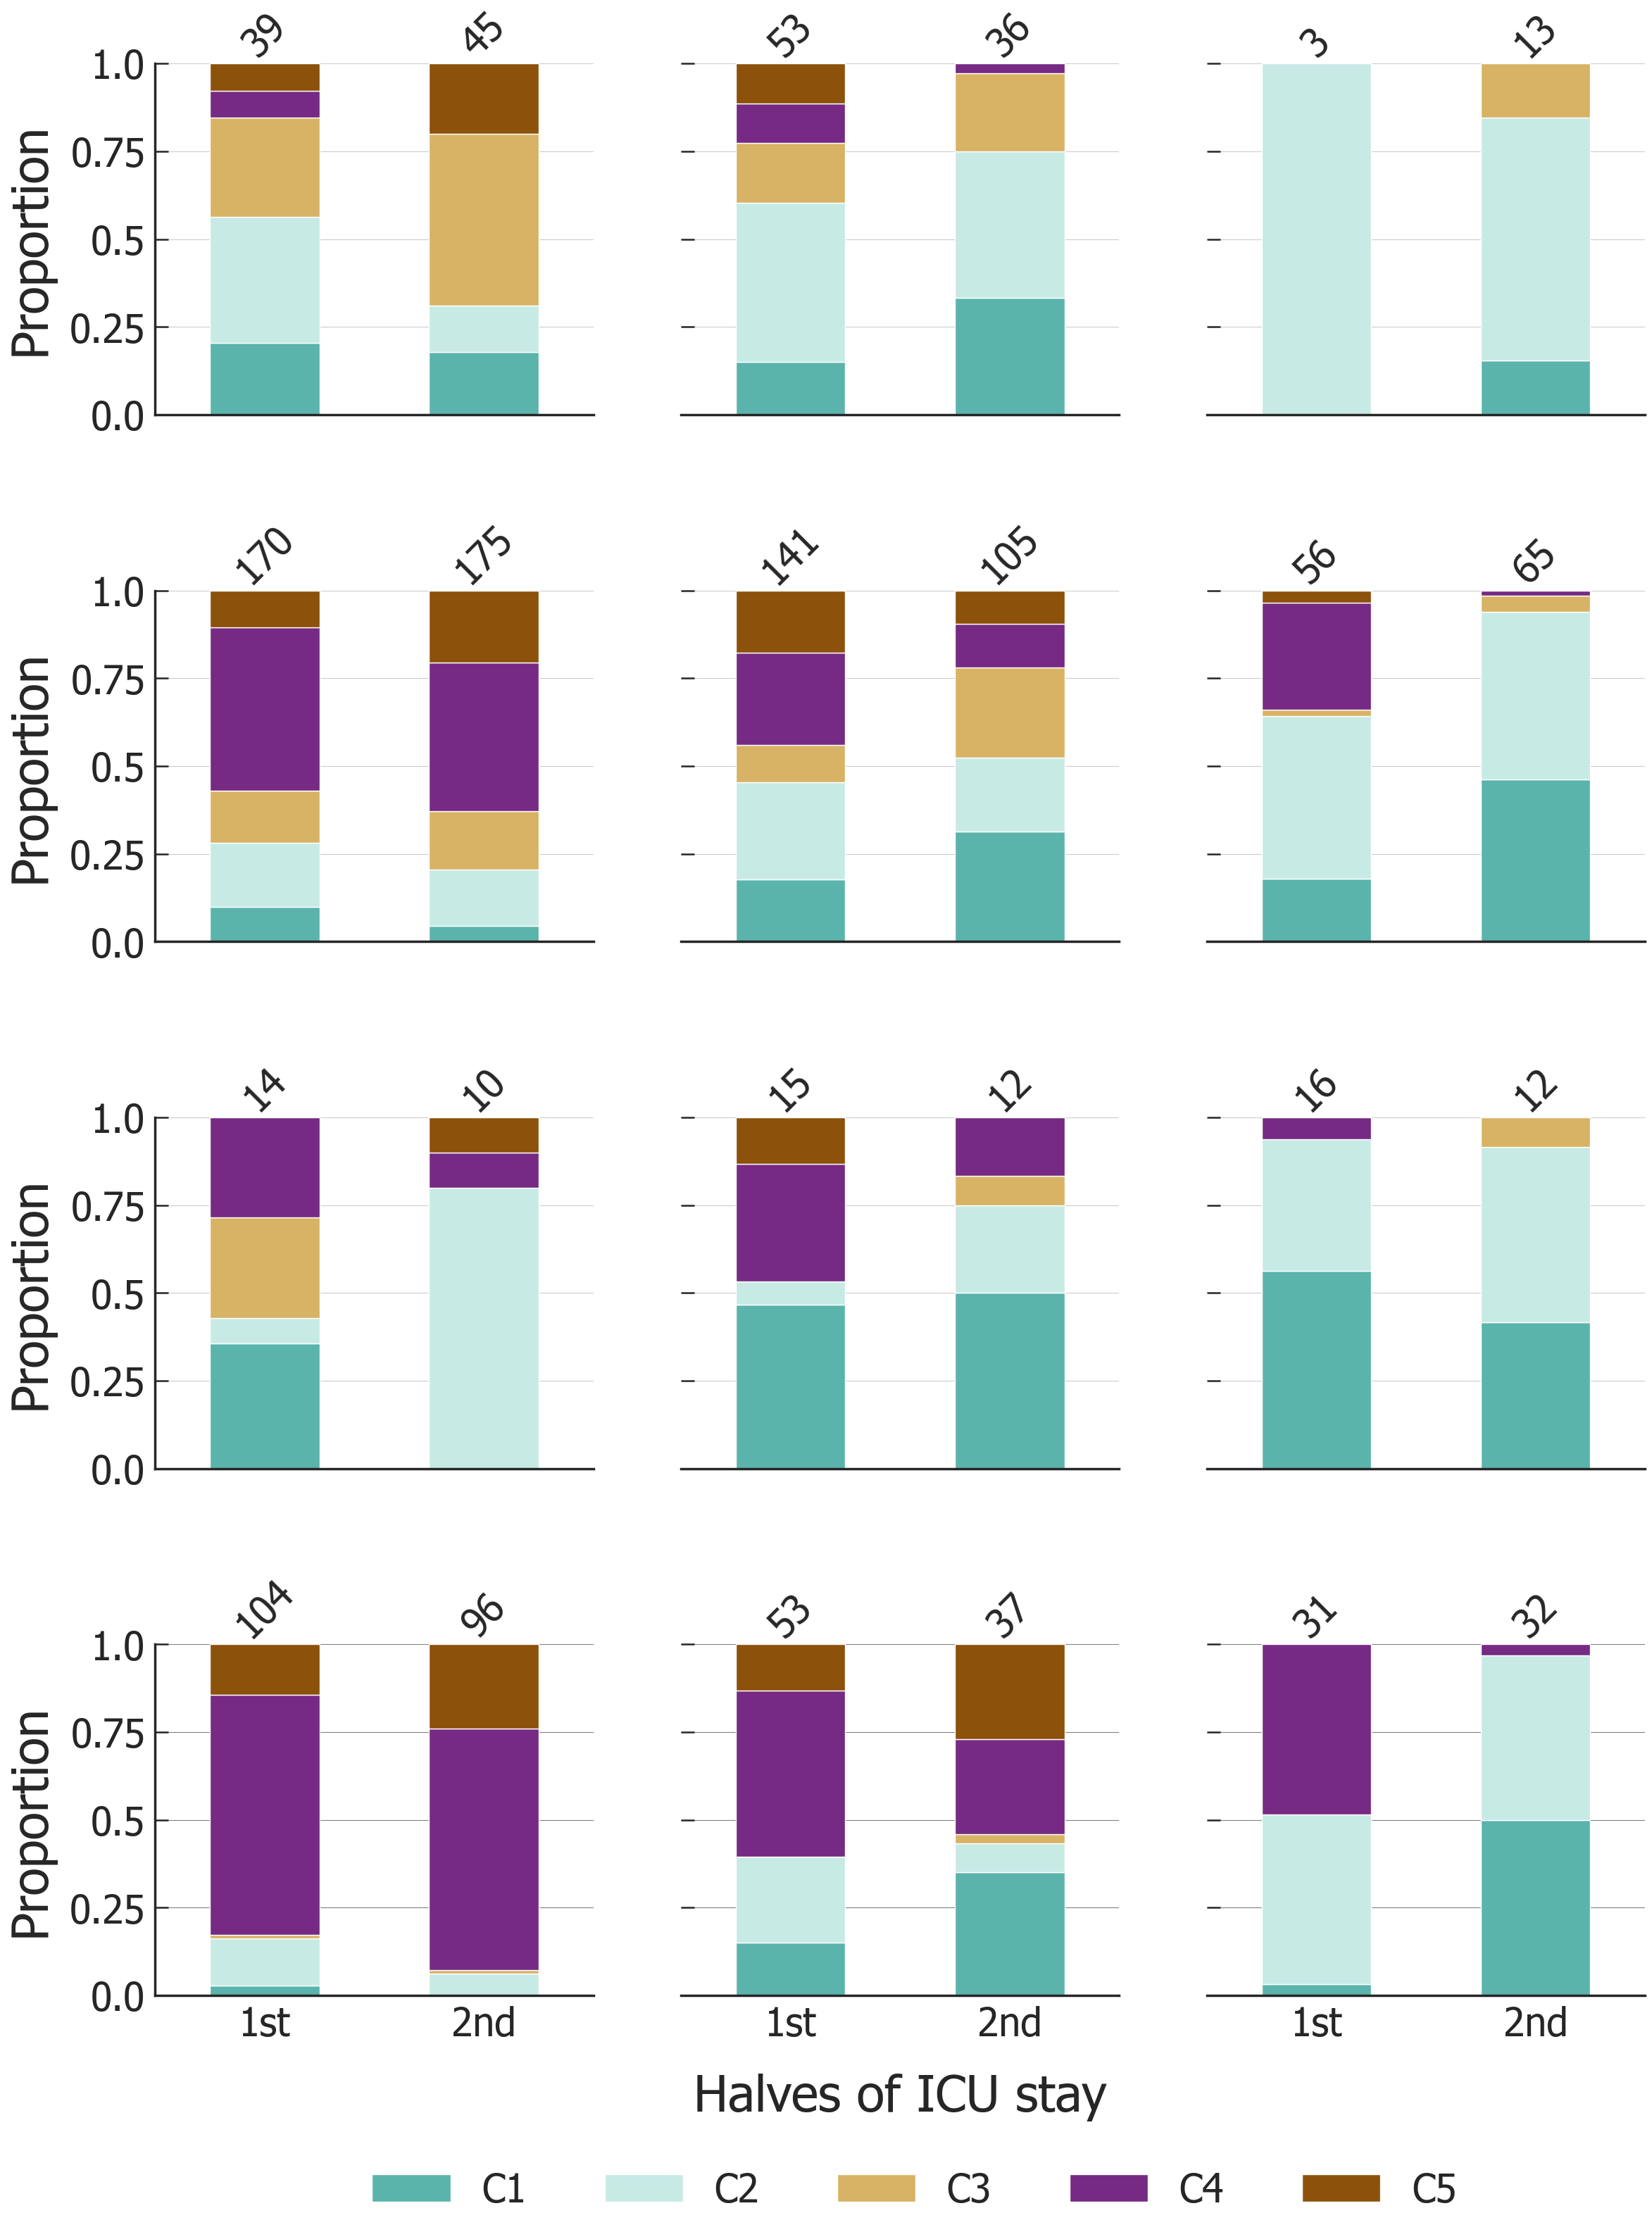

In [58]:
nc = 3
nr = 4
fig, axs = plt.subplots(nr, nc, figsize=plots.stdfigsize(nx=nc, ny=nr))

f1 = out_script_test.Patient_category=='Other Pneumonia'
f2 = out_script_test.Episode_etiology!='Bacterial/viral'
df = out_script_test[f1&f2].groupby(['cpros', 'discharge'], observed=False)['sofs+vtls_pred'].value_counts(normalize=True).unstack()
df1 = out_script_test[f1&f2].groupby(['cpros', 'discharge'], observed=False)['sofs+vtls_pred'].value_counts().unstack()

for i in range(3):
    df.xs(['Died', 'Other', 'Recovered'][i], level='discharge').plot(
        kind='bar', stacked=True, ax=axs[0,i], legend=False, rot=0,
        color={'C1': '#5ab4ac', 'C2': '#c7eae5', 'C3': '#d8b365', 'C4': '#762a83', 'C5': '#8c510a'}
    )
    axs[0,i].set_xlabel('')
    # axs[0,i].set_title(['Died', 'Other', 'Recovered'][i], fontdict={'fontsize':32})
    axs[0,0].set_ylabel('Proportion', fontsize=52)
    axs[0,i].grid(axis='y') 
    axs[0,i].set_ylim(0,1) 
    axs[0,i].set_yticks(np.arange(0,1.01,0.25))
    axs[0,i].set_yticklabels(np.arange(0,1.01,0.25), fontsize=40)
    
    if i!=0:
        axs[0,i].get_yaxis().set_visible(True)
        axs[0,i].spines['left'].set_visible(False)
        axs[0,i].set_yticks(np.arange(0,1.01,0.25))
        axs[0,i].set_yticklabels(['', '', '', '', ''], fontsize=40)
        
    axs[0,i].set_xticklabels([], fontsize=40)
    # axs[0,1].legend(['D', 'v', 'nv', 'S'], bbox_to_anchor=(0, 1), frameon=False, ncol=4, fontsize=30)

    for ip, p in enumerate(axs[0,i].patches):
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        if (ip//2 == 2):
            ann = df1.xs(['Died', 'Other', 'Recovered'][i], level='discharge').sum(axis=1).values[ip%2]
            axs[0,i].text(x+width/2, 1, 
                        '{:n}'.format(ann), 
                        horizontalalignment='center', verticalalignment='bottom', 
                        fontsize=40, rotation=45)
            
df = out_script_test.groupby(['cpros', 'discharge'], observed=False)['sofs+vtls_pred'].value_counts(normalize=True).unstack()
df1 = out_script_test.groupby(['cpros', 'discharge'], observed=False)['sofs+vtls_pred'].value_counts().unstack()

for i in range(3):
    df.xs(['Died', 'Other', 'Recovered'][i], level='discharge').plot(
        kind='bar', stacked=True, ax=axs[1,i], legend=False, rot=0, 
        color={'C1': '#5ab4ac', 'C2': '#c7eae5', 'C3': '#d8b365', 'C4': '#762a83', 'C5': '#8c510a'}
    )
    axs[1,i].set_xlabel('')
    # axs[0,i].set_title(['Died', 'Other', 'Recovered'][i], fontdict={'fontsize':32})
    axs[1,0].set_ylabel('Proportion', fontsize=52)
    axs[1,i].grid(axis='y') 
    axs[1,i].set_ylim(0,1) 
    axs[1,i].set_yticks(np.arange(0,1.01,0.25))
    axs[1,i].set_yticklabels(np.arange(0,1.01,0.25), fontsize=40)
    
    if i!=0:
        axs[1,i].get_yaxis().set_visible(True)
        axs[1,i].set_ylabel('')
        axs[1,i].spines['left'].set_visible(False)
        axs[1,i].set_yticks(np.arange(0,1.01,0.25))
        axs[1,i].set_yticklabels(['', '', '', '', ''])
        
    axs[1,i].set_xticklabels([], fontsize=40)
    for ip, p in enumerate(axs[1,i].patches):
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        if (ip//2 == 4):
            ann = df1.xs(['Died', 'Other', 'Recovered'][i], level='discharge').sum(axis=1).values[ip%2]
            axs[1,i].text(x+width/2, 1, 
                        '{:n}'.format(ann), 
                        horizontalalignment='center', verticalalignment='bottom', 
                        fontsize=40, rotation=45)

f1 = out_script_test.Patient_category.isin(['Other Viral Pneumonia'])
f2 = out_script_test.Episode_etiology!='Bacterial'
df = out_script_test[f1&f2].groupby(['cpros', 'discharge'], observed=False)['sofs+vtls_pred'].value_counts(normalize=True).unstack()
df1 = out_script_test[f1&f2].groupby(['cpros', 'discharge'], observed=False)['sofs+vtls_pred'].value_counts().unstack()

for i in range(3):
    df.xs(['Died', 'Other', 'Recovered'][i], level='discharge').plot(
        kind='bar', stacked=True, ax=axs[2,i], legend=False, rot=0, 
        color={'C1': '#5ab4ac', 'C2': '#c7eae5', 'C3': '#d8b365', 'C4': '#762a83', 'C5': '#8c510a'}
    )
    axs[2,i].set_xlabel('')
    # axs[0,i].set_title(['Died', 'Other', 'Recovered'][i], fontdict={'fontsize':32})
    axs[2,0].set_ylabel('Proportion', fontsize=52)
    axs[2,i].grid(axis='y') 
    axs[2,i].set_ylim(0,1) 
    axs[2,i].set_yticks(np.arange(0,1.01,0.25))
    axs[2,i].set_yticklabels(np.arange(0,1.01,0.25), fontsize=40)
    
    if i!=0:
        axs[2,i].get_yaxis().set_visible(True)
        axs[2,i].set_ylabel('')
        axs[2,i].spines['left'].set_visible(False)
        axs[2,i].set_yticks(np.arange(0,1.01,0.25))
        axs[2,i].set_yticklabels(['', '', '', '', ''])
        
    axs[2,i].set_xticklabels([], fontsize=40)
    for ip, p in enumerate(axs[2,i].patches):
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        if (ip//2 == 4):
            ann = df1.xs(['Died', 'Other', 'Recovered'][i], level='discharge').sum(axis=1).values[ip%2]
            axs[2,i].text(x+width/2, 1, 
                        '{:n}'.format(ann), 
                        horizontalalignment='center', verticalalignment='bottom', 
                        fontsize=40, rotation=45)
            
f1 = out_script_test.Patient_category=='COVID-19'
f2 = out_script_test.Episode_etiology!='Bacterial'
df = out_script_test[f1&f2].groupby(['cpros', 'discharge'], observed=False)['sofs+vtls_pred'].value_counts(normalize=True).unstack()
df1 = out_script_test[f1&f2].groupby(['cpros', 'discharge'], observed=False)['sofs+vtls_pred'].value_counts().unstack()

for i in range(3):
    df.xs(['Died', 'Other', 'Recovered'][i], level='discharge').plot(
        kind='bar', stacked=True, ax=axs[3,i], legend=False, rot=0, 
        color={'C1': '#5ab4ac', 'C2': '#c7eae5', 'C3': '#d8b365', 'C4': '#762a83', 'C5': '#8c510a'}
    )
    if i==1:
        axs[3,i].set_xlabel('Halves of ICU stay', fontsize=52, labelpad=30)
    else:
        axs[3,i].set_xlabel('')
    
    axs[3,0].set_ylabel('Proportion', fontsize=52)
    axs[3,i].grid(axis='y', c='Gray') 
    axs[3,i].set_ylim(0,1)
    axs[3,i].set_yticks(np.arange(0,1.01,0.25))
    axs[3,i].set_yticklabels(np.arange(0,1.01,0.25), fontsize=40)
    
    if i!=0:
        axs[3,i].get_yaxis().set_visible(True)
        axs[3,i].spines['left'].set_visible(False)
        axs[3,i].set_yticks(np.arange(0,1.01,0.25))
        axs[3,i].set_yticklabels(['', '', '', '', ''])
        
    axs[3,i].set_xticklabels(['1st', '2nd'], fontsize=40)
    for ip, p in enumerate(axs[3,i].patches):
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        if (ip//2 == 4):
            ann = df1.xs(['Died', 'Other', 'Recovered'][i], level='discharge').sum(axis=1).values[ip%2]
            axs[3,i].text(x+width/2, 1, 
                        '{:n}'.format(ann), 
                        horizontalalignment='center', verticalalignment='bottom', 
                        fontsize=40, rotation=45)
axs[3,1].legend(['C1', 'C2', 'C3', 'C4', 'C5'], bbox_to_anchor=(1.85,-.4), frameon=False, ncol=5, fontsize=40)
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=.5, wspace=0.2)

In [69]:
mimic_pat_category = pd.read_csv(os.path.join(mimic_dir, 'mimic_pat_category.csv'))

In [70]:
out_mimic_pat = mimic_pat_category.merge(out_mimic_test)

In [71]:
out_mimic_pat['pros'] = out_mimic_pat.icu_day/out_mimic_pat.los_icu 
out_mimic_pat.loc[out_mimic_pat.Number_of_ICU_stays!=1, 'pros'] = np.nan
out_mimic_pat['cpros'] = pd.cut(out_mimic_pat['pros'], bins=np.linspace(0,1,6), include_lowest=True, labels=np.arange(1,6))

In [72]:
out_mimic_pat.Patient_category.unique()

array(['Indeterminate', 'VAP', 'Bacterial', 'Fungal', 'Other Pneumonia',
       'Other Viral Pneumonia'], dtype=object)

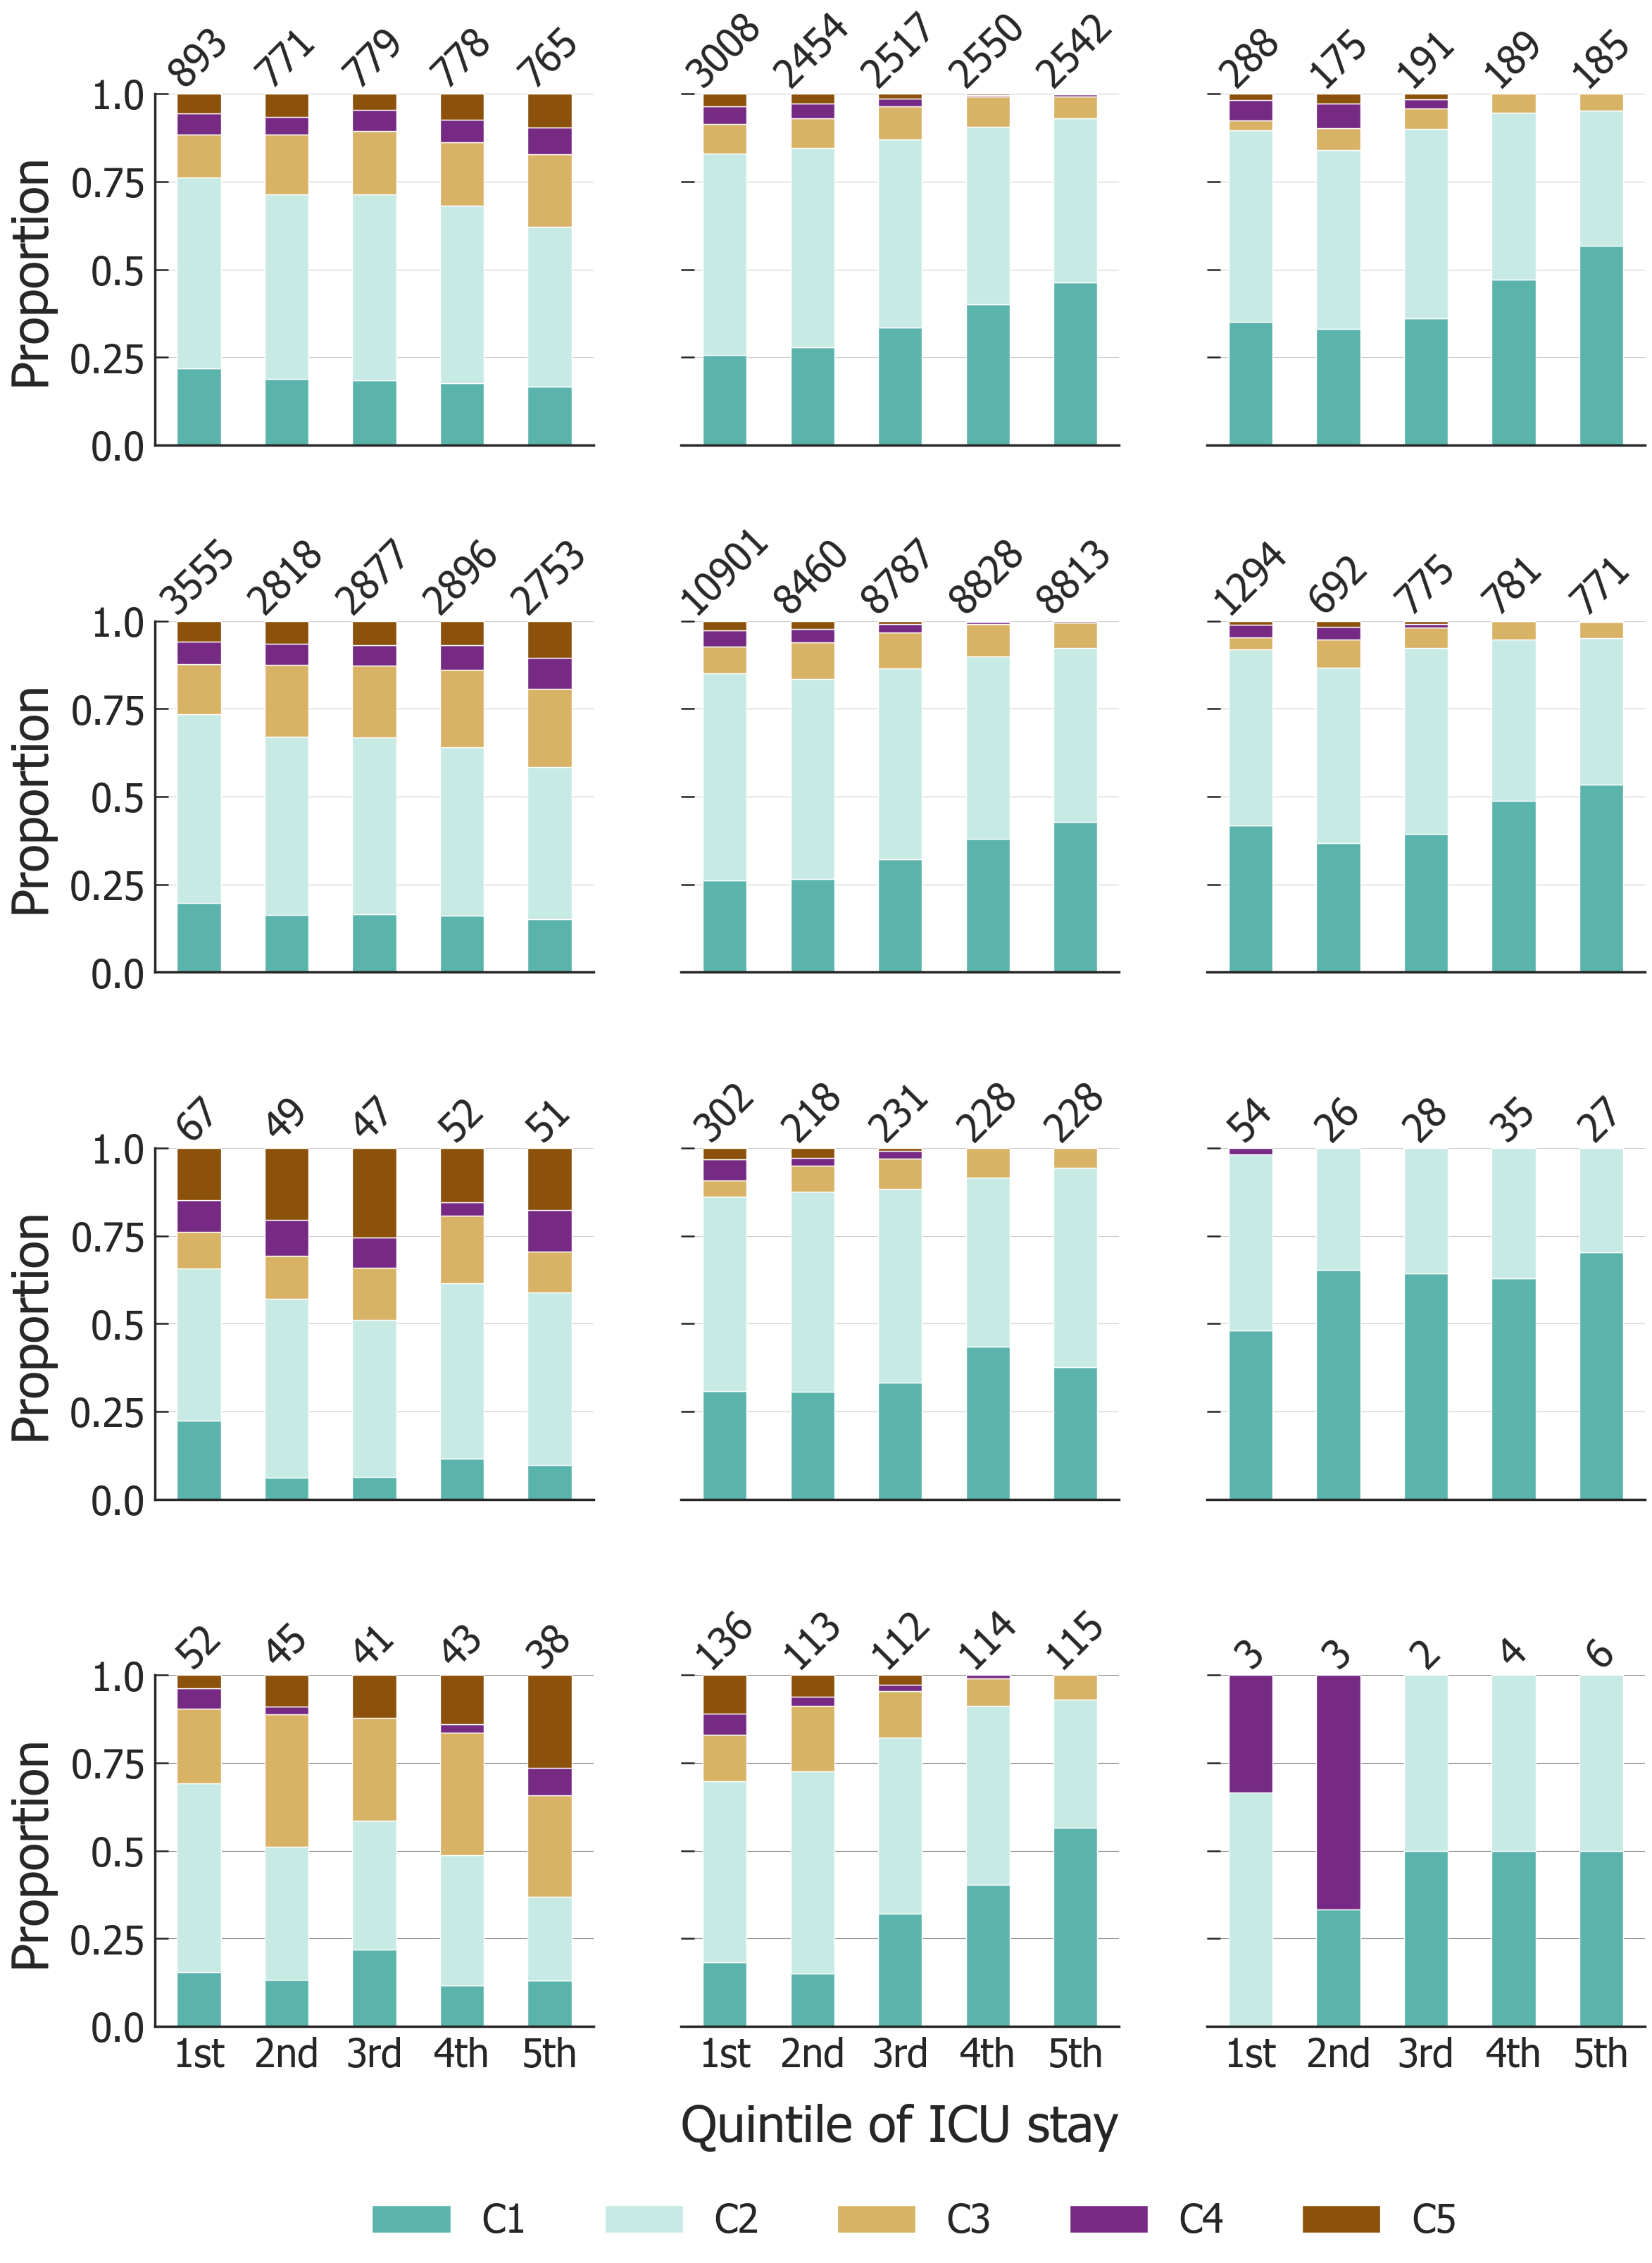

In [74]:
nc = 3
nr = 4
fig, axs = plt.subplots(nr, nc, figsize=plots.stdfigsize(nx=nc, ny=nr))

f1 = out_mimic_pat.Patient_category=='Bacterial'
df = out_mimic_pat[f1].groupby(['cpros', 'discharge'], observed=False)['script_pred'].value_counts(normalize=True).unstack()
df1 = out_mimic_pat[f1].groupby(['cpros', 'discharge'], observed=False)['script_pred'].value_counts().unstack()

for i in range(3):
    df.xs(['Died', 'Other', 'Recovered'][i], level='discharge').plot(
        kind='bar', stacked=True, ax=axs[0,i], legend=False, rot=0,
        color={'C1': '#5ab4ac', 'C2': '#c7eae5', 'C3': '#d8b365', 'C4': '#762a83', 'C5': '#8c510a'}
    )
    axs[0,i].set_xlabel('')
    # axs[0,i].set_title(['Died', 'Other', 'Recovered'][i], fontdict={'fontsize':32})
    axs[0,0].set_ylabel('Proportion', fontsize=52)
    axs[0,i].grid(axis='y') 
    axs[0,i].set_ylim(0,1) 
    axs[0,i].set_yticks(np.arange(0,1.01,0.25))
    axs[0,i].set_yticklabels(np.arange(0,1.01,0.25), fontsize=40)
    
    if i!=0:
        axs[0,i].get_yaxis().set_visible(True)
        axs[0,i].spines['left'].set_visible(False)
        axs[0,i].set_yticks(np.arange(0,1.01,0.25))
        axs[0,i].set_yticklabels(['', '', '', '', ''])
        
    axs[0,i].set_xticklabels([], fontsize=32)
    # axs[0,1].legend(['D', 'v', 'nv', 'S'], bbox_to_anchor=(0, 1), frameon=False, ncol=4, fontsize=30)

    for ip, p in enumerate(axs[0,i].patches):
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        if (ip//5 == 4):
            ann = df1.xs(['Died', 'Other', 'Recovered'][i], level='discharge').sum(axis=1).values[ip%5]
            axs[0,i].text(x+width/2, 1, 
                        '{:n}'.format(ann), 
                        horizontalalignment='center', verticalalignment='bottom', 
                        fontsize=40, rotation=45)
            
df = out_mimic_pat.groupby(['cpros', 'discharge'], observed=False)['script_pred'].value_counts(normalize=True).unstack()
df1 = out_mimic_pat.groupby(['cpros', 'discharge'], observed=False)['script_pred'].value_counts().unstack()

for i in range(3):
    df.xs(['Died', 'Other', 'Recovered'][i], level='discharge').plot(
        kind='bar', stacked=True, ax=axs[1,i], legend=False, rot=0, 
        color={'C1': '#5ab4ac', 'C2': '#c7eae5', 'C3': '#d8b365', 'C4': '#762a83', 'C5': '#8c510a'}
    )
    axs[1,i].set_xlabel('')
    # axs[0,i].set_title(['Died', 'Other', 'Recovered'][i], fontdict={'fontsize':32})
    axs[1,0].set_ylabel('Proportion', fontsize=52)
    axs[1,i].grid(axis='y') 
    axs[1,i].set_ylim(0,1) 
    axs[1,i].set_yticks(np.arange(0,1.01,0.25))
    axs[1,i].set_yticklabels(np.arange(0,1.01,0.25), fontsize=40)
    
    if i!=0:
        axs[1,i].get_yaxis().set_visible(True)
        axs[1,i].set_ylabel('')
        axs[1,i].spines['left'].set_visible(False)
        axs[1,i].set_yticks(np.arange(0,1.01,0.25))
        axs[1,i].set_yticklabels(['', '', '', '', ''])
        
    axs[1,i].set_xticklabels([], fontsize=40)
    for ip, p in enumerate(axs[1,i].patches):
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        if (ip//5 == 4):
            ann = df1.xs(['Died', 'Other', 'Recovered'][i], level='discharge').sum(axis=1).values[ip%5]
            axs[1,i].text(x+width/2, 1, 
                        '{:n}'.format(ann), 
                        horizontalalignment='center', verticalalignment='bottom', 
                        fontsize=40, rotation=45)

f1 = out_mimic_pat.Patient_category.isin(['Other Viral Pneumonia'])
df = out_mimic_pat[f1].groupby(['cpros', 'discharge'], observed=False)['script_pred'].value_counts(normalize=True).unstack()
df1 = out_mimic_pat[f1].groupby(['cpros', 'discharge'], observed=False)['script_pred'].value_counts().unstack()

for i in range(3):
    df.xs(['Died', 'Other', 'Recovered'][i], level='discharge').plot(
        kind='bar', stacked=True, ax=axs[2,i], legend=False, rot=0, 
        color={'C1': '#5ab4ac', 'C2': '#c7eae5', 'C3': '#d8b365', 'C4': '#762a83', 'C5': '#8c510a'}
    )
    axs[2,i].set_xlabel('')
    # axs[0,i].set_title(['Died', 'Other', 'Recovered'][i], fontdict={'fontsize':32})
    axs[2,0].set_ylabel('Proportion', fontsize=52)
    axs[2,i].grid(axis='y') 
    axs[2,i].set_ylim(0,1) 
    axs[2,i].set_yticks(np.arange(0,1.01,0.25))
    axs[2,i].set_yticklabels(np.arange(0,1.01,0.25), fontsize=40)
    
    if i!=0:
        axs[2,i].get_yaxis().set_visible(True)
        axs[2,i].set_ylabel('')
        axs[2,i].spines['left'].set_visible(False)
        axs[2,i].set_yticks(np.arange(0,1.01,0.25))
        axs[2,i].set_yticklabels(['', '', '', '', ''])
        
    axs[2,i].set_xticklabels([], fontsize=32)
    for ip, p in enumerate(axs[2,i].patches):
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        if (ip//5 == 4):
            ann = df1.xs(['Died', 'Other', 'Recovered'][i], level='discharge').sum(axis=1).values[ip%5]
            axs[2,i].text(x+width/2, 1, 
                        '{:n}'.format(ann), 
                        horizontalalignment='center', verticalalignment='bottom', 
                        fontsize=40, rotation=45)
            
f1 = out_mimic_pat.Patient_category=='Fungal'
df = out_mimic_pat[f1].groupby(['cpros', 'discharge'], observed=False)['script_pred'].value_counts(normalize=True).unstack()
df1 = out_mimic_pat[f1].groupby(['cpros', 'discharge'], observed=False)['script_pred'].value_counts().unstack()

for i in range(3):
    df.xs(['Died', 'Other', 'Recovered'][i], level='discharge').plot(
        kind='bar', stacked=True, ax=axs[3,i], legend=False, rot=0, 
        color={'C1': '#5ab4ac', 'C2': '#c7eae5', 'C3': '#d8b365', 'C4': '#762a83', 'C5': '#8c510a'}
    )
    if i==1:
        axs[3,i].set_xlabel('Quintile of ICU stay', fontsize=52, labelpad=30)
    else:
        axs[3,i].set_xlabel('')
    
    axs[3,0].set_ylabel('Proportion', fontsize=52)
    axs[3,i].grid(axis='y', c='Gray') 
    axs[3,i].set_ylim(0,1)
    axs[3,i].set_yticks(np.arange(0,1.01,0.25))
    axs[3,i].set_yticklabels(np.arange(0,1.01,0.25), fontsize=40)
    
    if i!=0:
        axs[3,i].get_yaxis().set_visible(True)
        axs[3,i].spines['left'].set_visible(False)
        axs[3,i].set_yticks(np.arange(0,1.01,0.25))
        axs[3,i].set_yticklabels(['', '', '', '', ''])
        
    axs[3,i].set_xticklabels(['1st', '2nd', '3rd', '4th', '5th'], fontsize=40)
    for ip, p in enumerate(axs[3,i].patches):
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        if (ip//5 == 4):
            ann = df1.xs(['Died', 'Other', 'Recovered'][i], level='discharge').sum(axis=1).values[ip%5]
            axs[3,i].text(x+width/2, 1, 
                        '{:n}'.format(ann), 
                        horizontalalignment='center', verticalalignment='bottom', 
                        fontsize=40, rotation=45)
axs[3,1].legend(['C1', 'C2', 'C3', 'C4', 'C5'], bbox_to_anchor=(1.85,-.4), frameon=False, ncol=5, fontsize=40)
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=.5, wspace=0.2)

## states transition probability

In [75]:
def calculate_transition_matrix(
    df, 
    state_col_name='states', 
    patient_id_col_name='Patient_id', 
    icu_stay_col_name='ICU_stay', 
    icu_day_col_name='ICU_day', 
    window_length=3
):
    # Create a new column that combines patient ID and ICU stay for easier grouping
    df['Patient_ICU'] = df[patient_id_col_name].astype(str) + "_" + df[icu_stay_col_name].astype(str)

    # Drop rows where the state column is NaN
    df = df.dropna(subset=[state_col_name])

    # Initialize an empty transition matrix
    unique_states = df[state_col_name].sort_values().unique()
    transition_matrix = pd.DataFrame(0, index=unique_states, columns=unique_states)

    # Calculate directional transitions within each sliding window
    for _, group in df.groupby('Patient_ICU'):
        group = group.sort_values(icu_day_col_name)  # Ensure the group is sorted by ICU day
        group = group.reset_index(drop=True)
        
        for start in range(len(group) - 1):
            for end in range(start + 1, len(group)):
                # Check if the difference between ICU days is within the window length
                if group.loc[end, icu_day_col_name] - group.loc[start, icu_day_col_name] <= window_length - 1:
                    first_state = group.loc[start, state_col_name]
                    next_state = group.loc[end, state_col_name]
                    transition_matrix.loc[first_state, next_state] += 1
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0).fillna(0)
    
    return transition_matrix

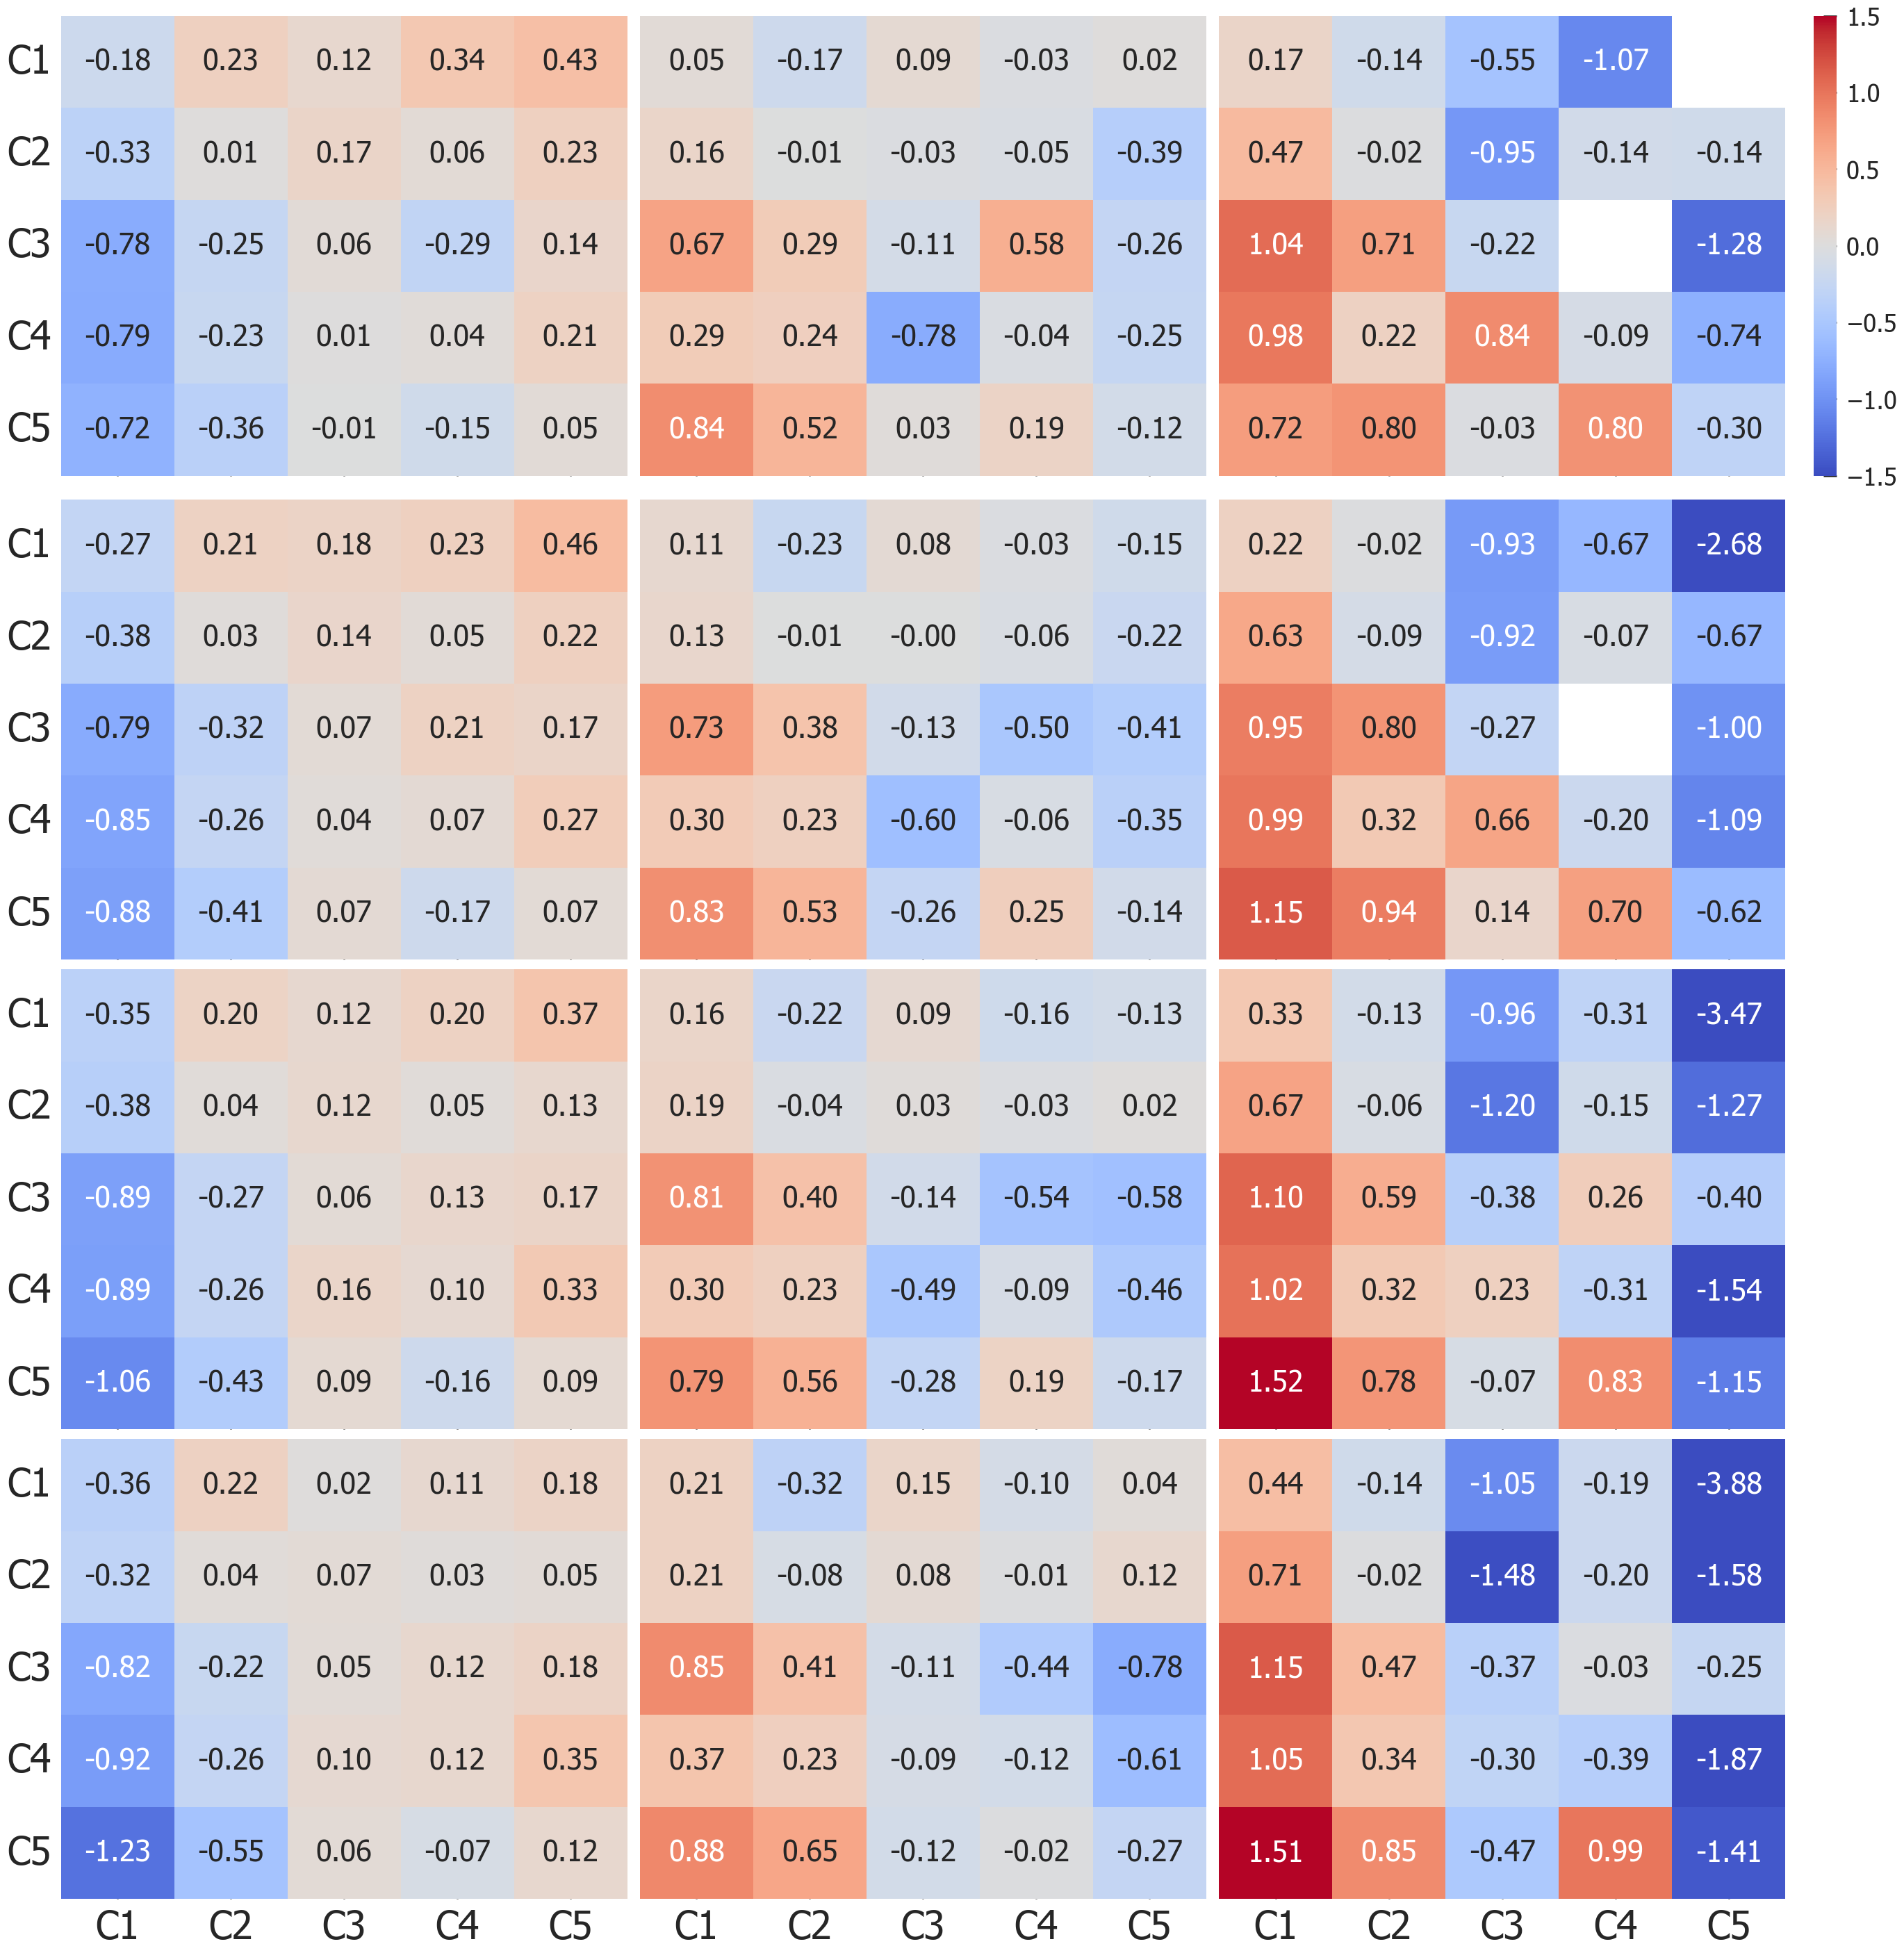

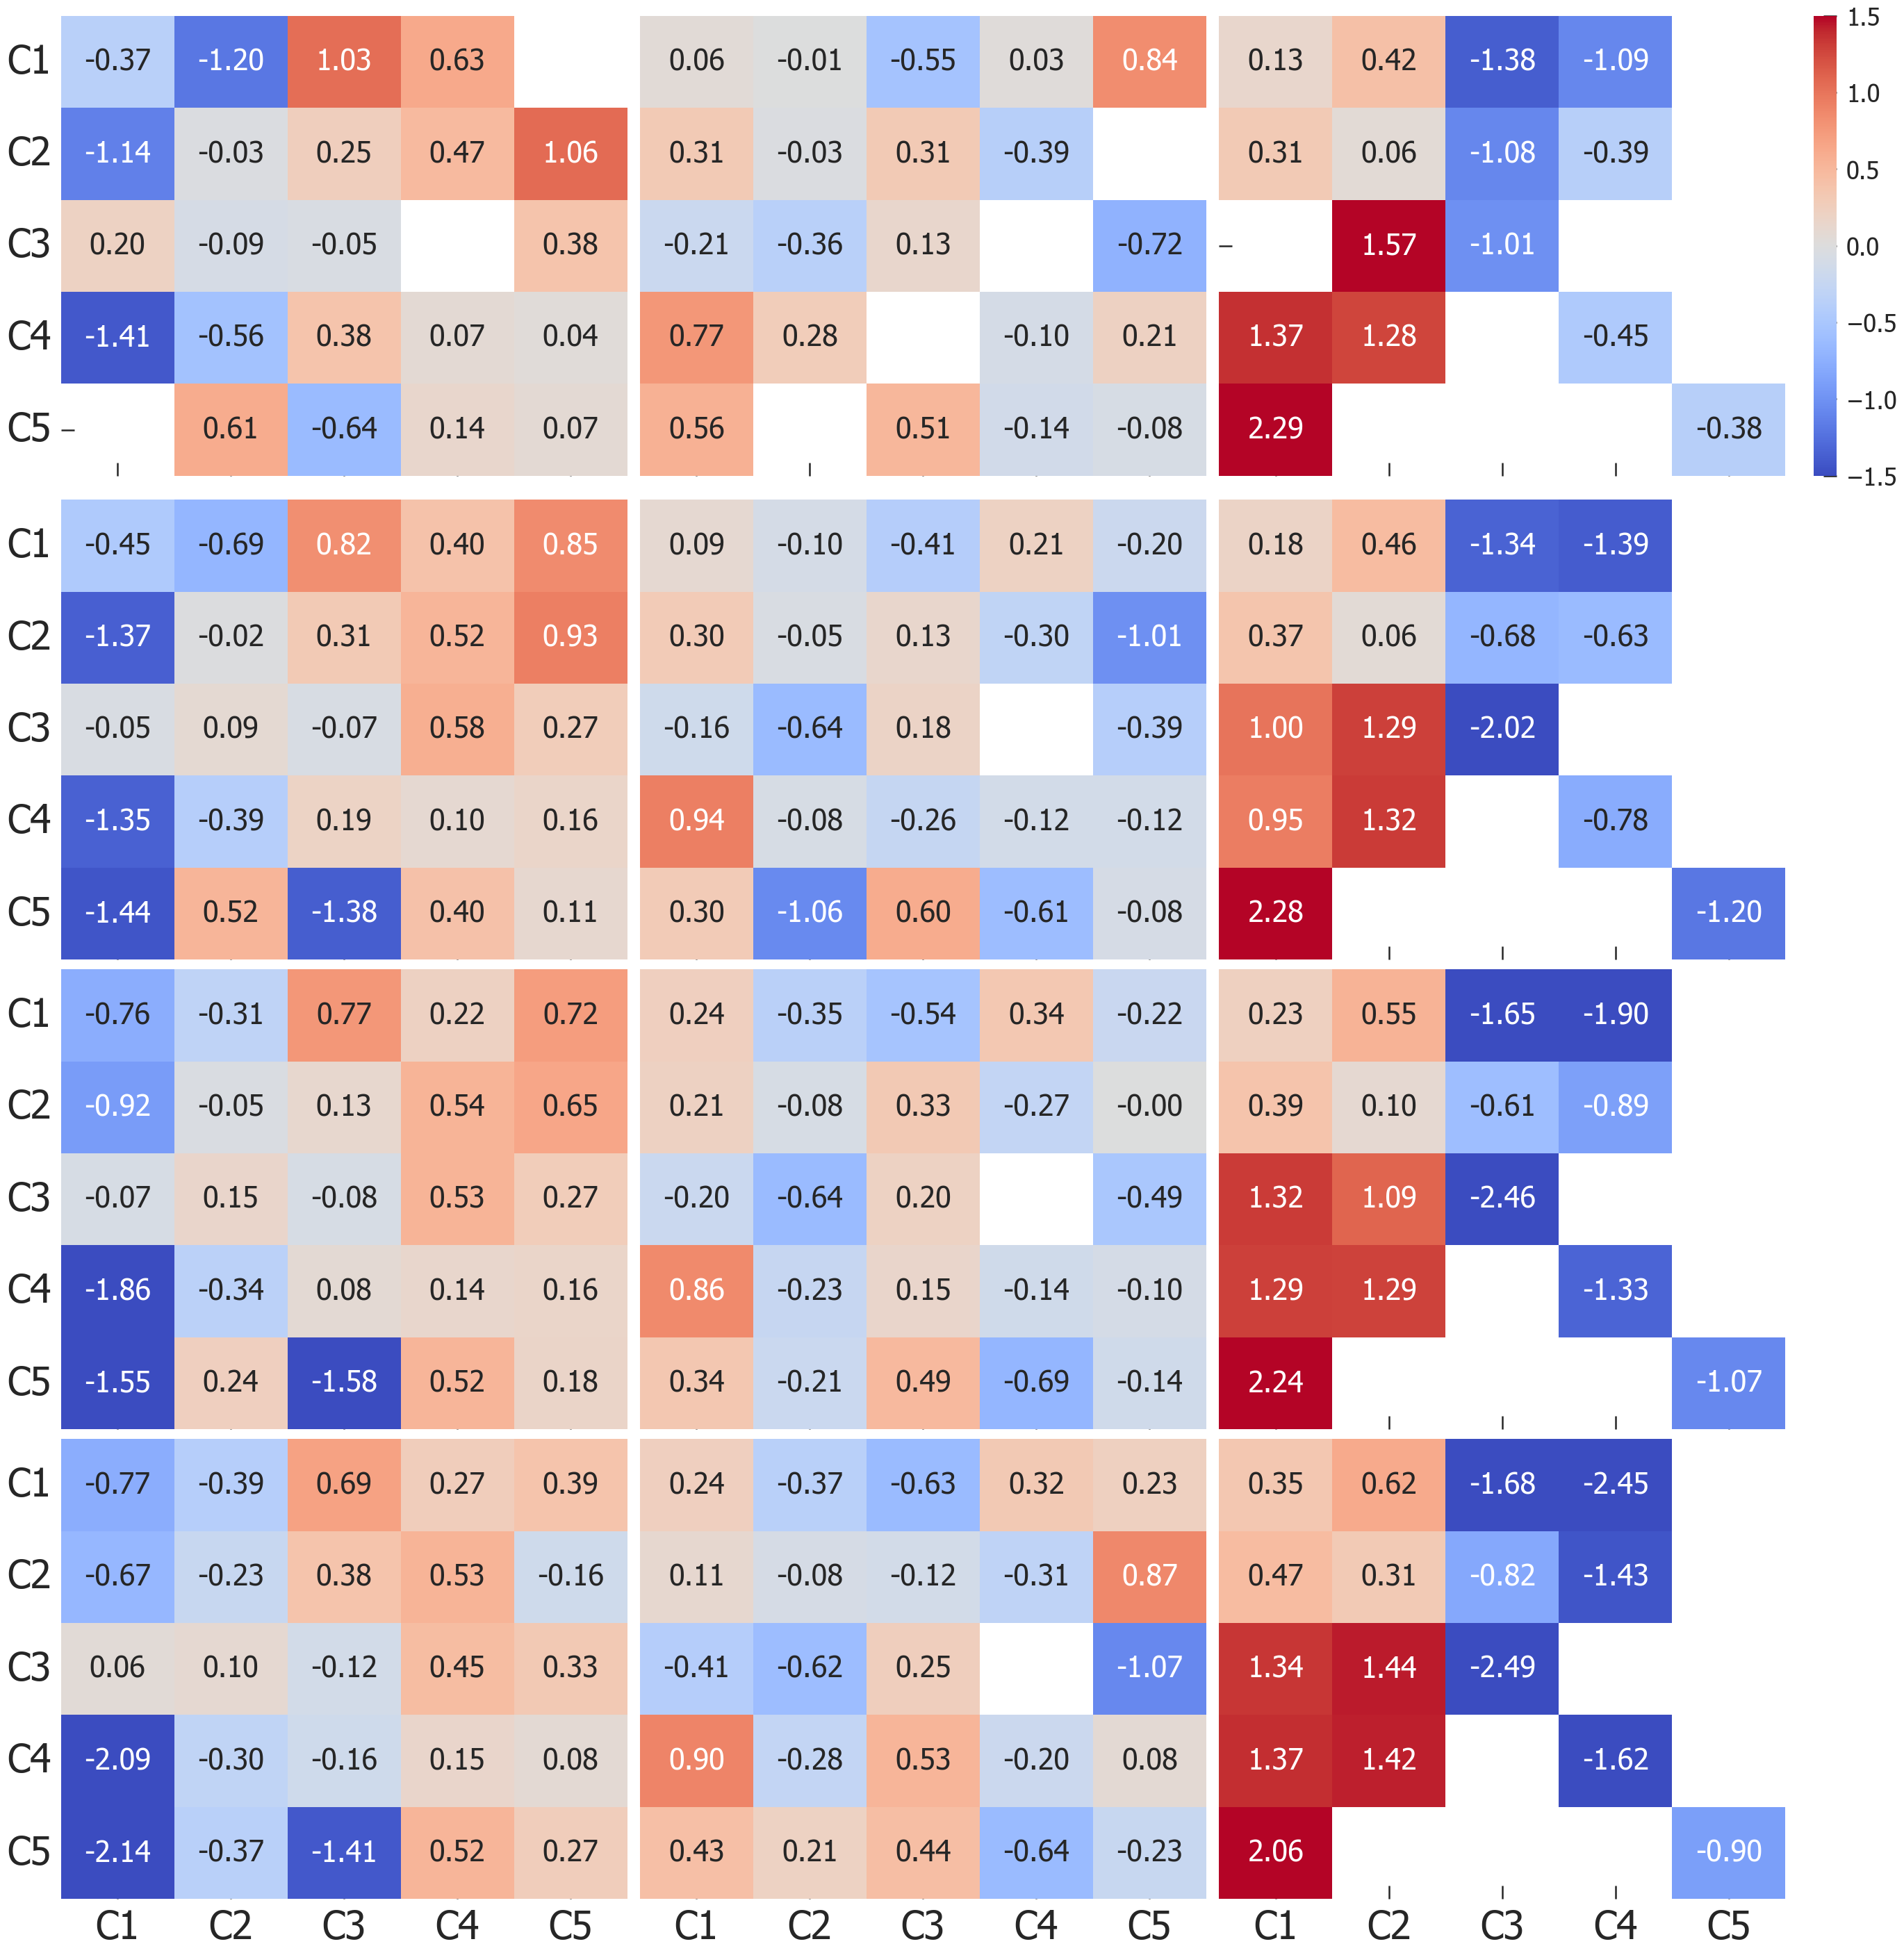

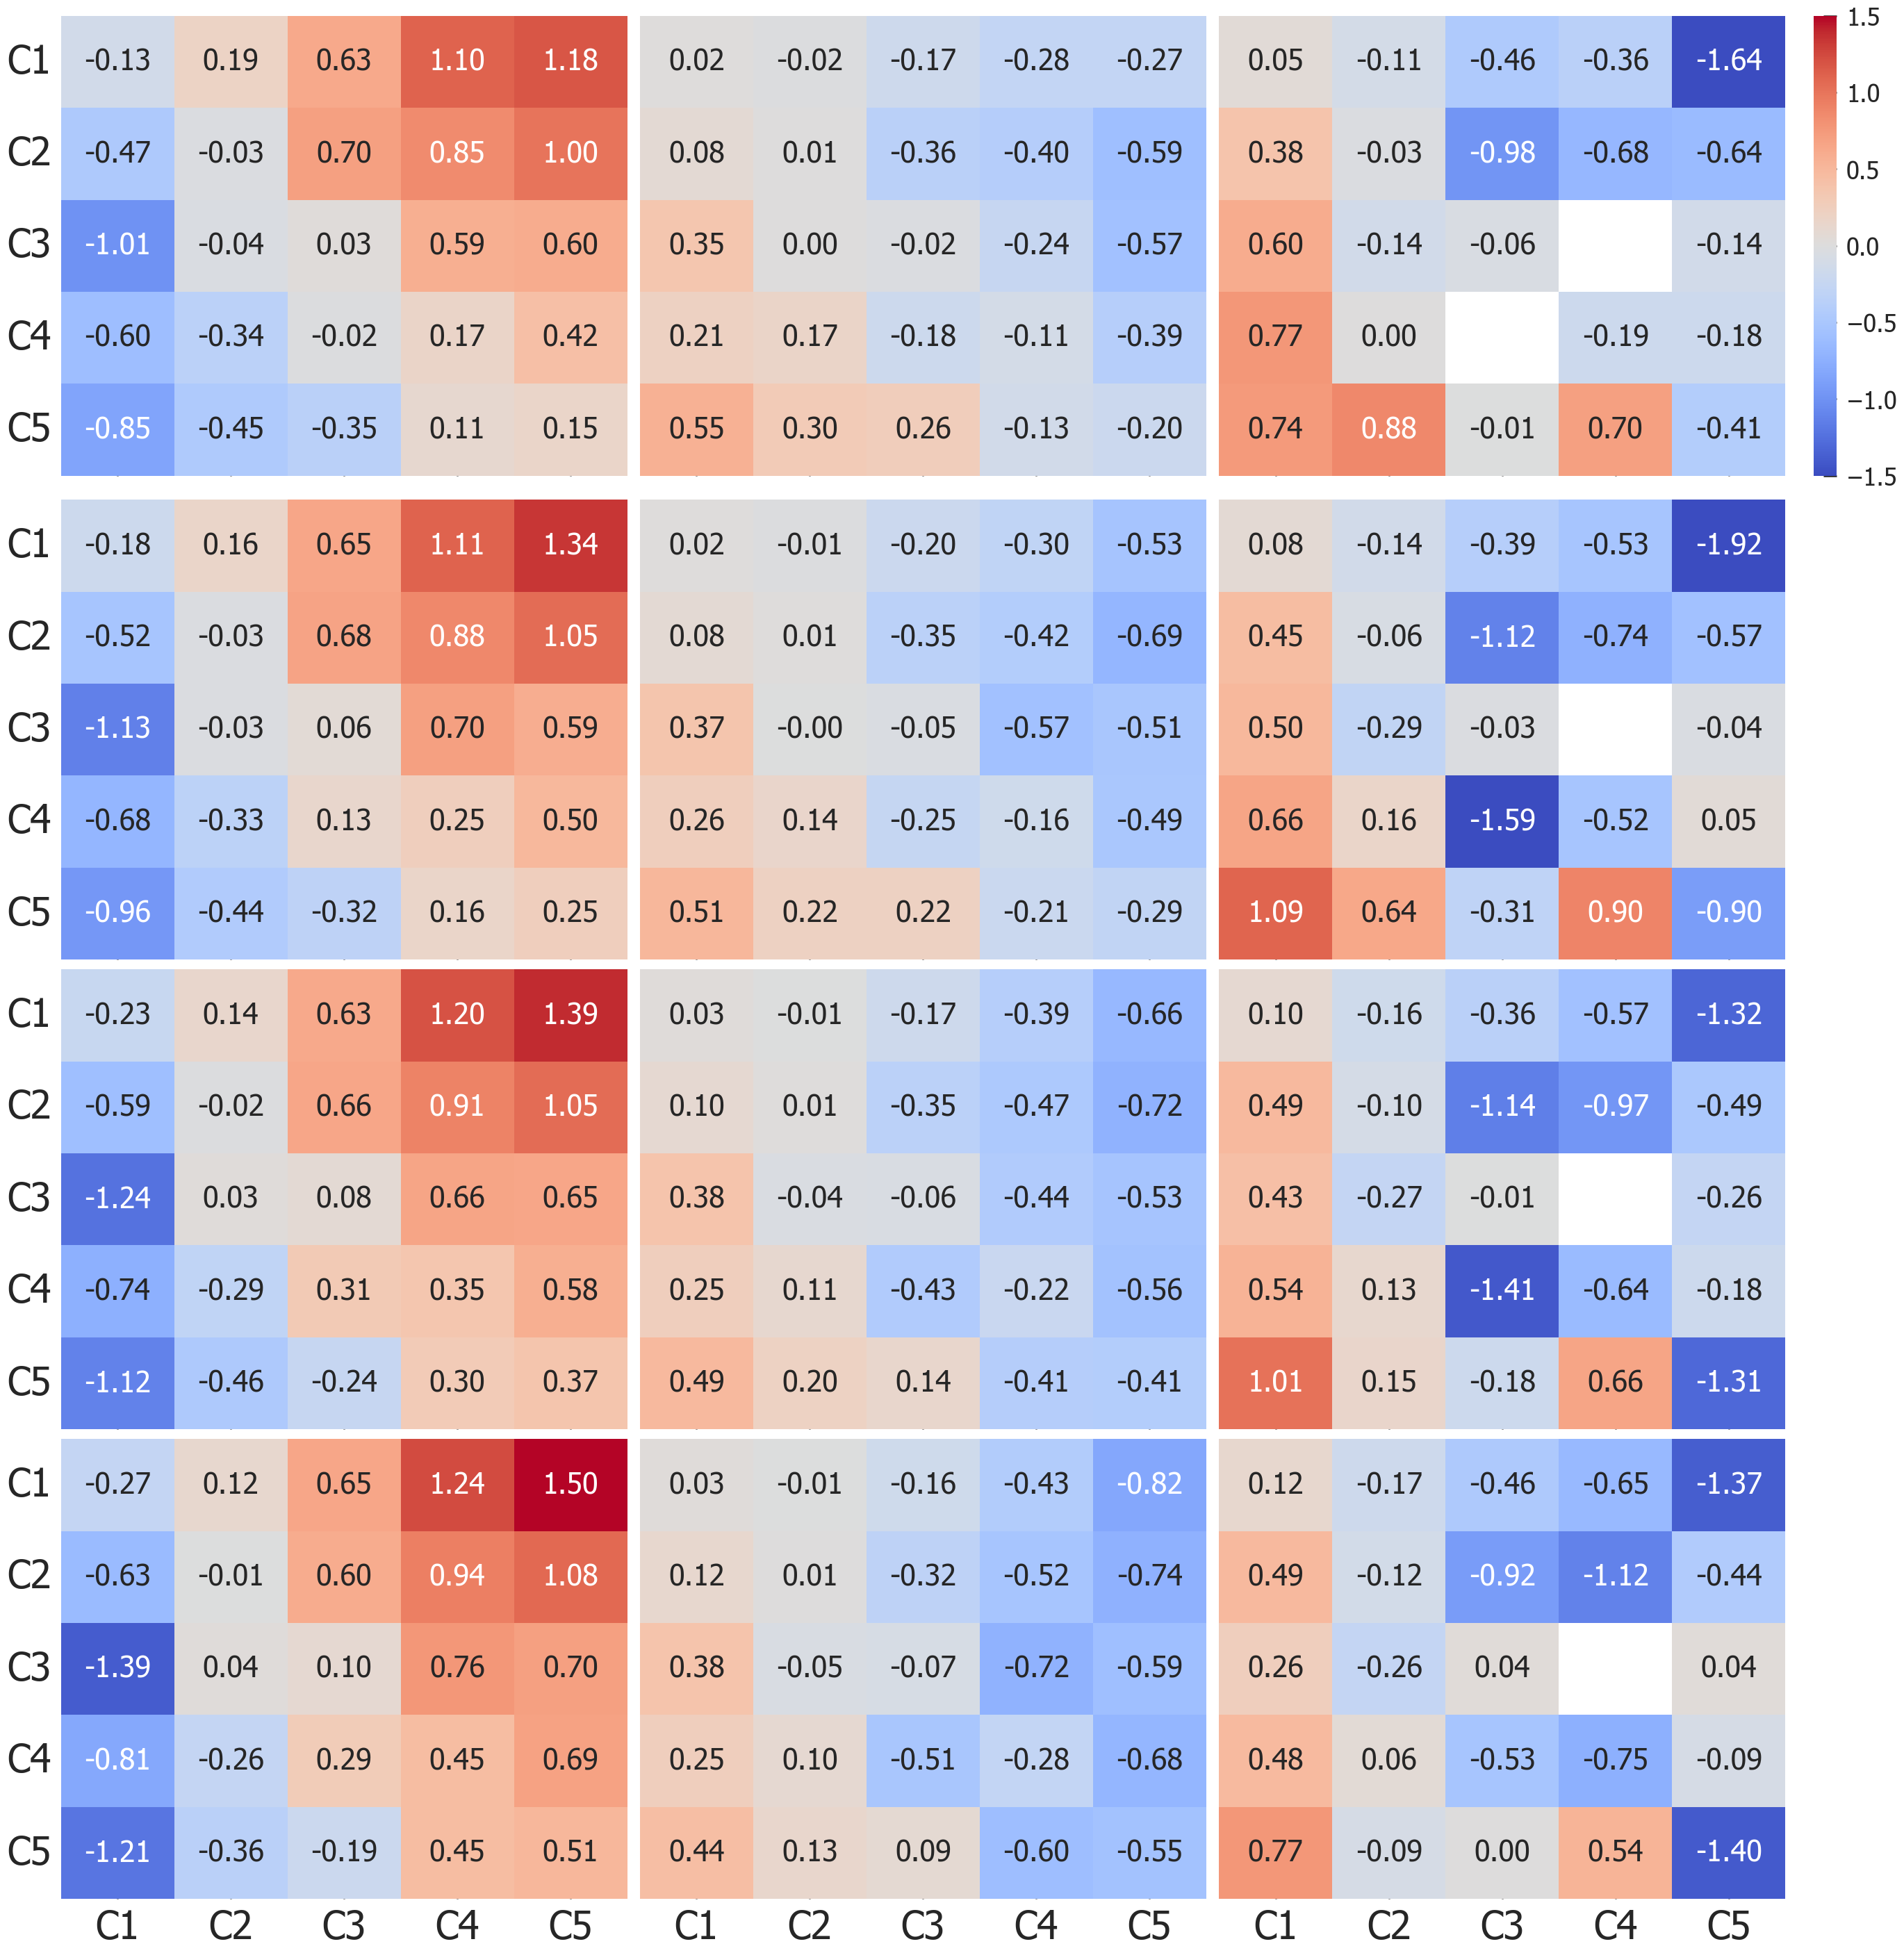

In [76]:
for cohort in ['script_train', 'script_test', 'mimic_test']:
    if cohort == 'script_train':
        data = out_script_train
    elif cohort == 'script_test':
        data = out_script_test
    elif cohort == 'mimic_test':
        data = out_mimic_test

    fig, axs = plt.subplots(4,3, figsize=plots.stdfigsize(nx=3, ny=4), sharex=True, sharey=True, constrained_layout=True)
    
    if cohort.startswith('script'):
        for i in range(3):
            dsc = ['Died', 'Other', 'Recovered'][i]  
            for j in range(4):
                dd = [2,4,8,16][j]
                mtx_dsc = calculate_transition_matrix(
                    data[data.discharge==dsc].reset_index(drop=True), state_col_name='sofs+vtls_pred', 
                    icu_stay_col_name='ICU_stay', icu_day_col_name='ICU_day', 
                    window_length=dd
                )
                mtx_all = calculate_transition_matrix(
                    data, state_col_name='sofs+vtls_pred', 
                    icu_stay_col_name='ICU_stay', icu_day_col_name='ICU_day', 
                    window_length=dd
                )
                ratio_matrix = mtx_dsc / mtx_all
                small_value = 1e-10
                big_value = 1e10
                ratio_matrix = ratio_matrix.replace([-np.inf, 0], np.nan).fillna(small_value).replace(np.inf, big_value)

                htm = np.log(ratio_matrix)
                mask = abs(htm)>10
                sns.heatmap(htm, cmap='coolwarm', annot=True, fmt=".2f", cbar=True if (i==2)&(j==0) else False, center=0, ax=axs[j,i], annot_kws={"fontsize": 30}, vmin=-1.5, vmax=1.5, mask=mask)
                axs[j,i].tick_params(axis='y', rotation=0)
                if i==0:
                    axs[j,i].set_yticklabels(axs[j,i].get_yticklabels(), rotation=0, fontsize=40)
                if j==3:
                    axs[j,i].set_xticklabels(axs[j,i].get_xticklabels(), rotation=0, fontsize=40)
    
    else:
        for i in range(3):
            dsc = ['Died', 'Other', 'Recovered'][i]  
            for j in range(4):
                dd = [2,4,8,16][j]
                mtx_dsc = calculate_transition_matrix(
                    data[data.discharge==dsc].reset_index(drop=True), state_col_name='script_pred', 
                    patient_id_col_name='subject_id', icu_stay_col_name='stay_id', icu_day_col_name='icu_day', 
                    window_length=dd
                )
                mtx_all = calculate_transition_matrix(
                    data, state_col_name='script_pred', 
                    patient_id_col_name='subject_id', icu_stay_col_name='stay_id', icu_day_col_name='icu_day',
                    window_length=dd
                )
                ratio_matrix = mtx_dsc / mtx_all
                small_value = 1e-10
                big_value = 1e10
                ratio_matrix = ratio_matrix.replace([-np.inf, 0], np.nan).fillna(small_value).replace(np.inf, big_value)

                htm = np.log(ratio_matrix)
                mask = abs(htm)>10
                sns.heatmap(htm, cmap='coolwarm', annot=True, fmt=".2f", cbar=True if (i==2)&(j==0) else False, center=0, ax=axs[j,i], annot_kws={"fontsize": 30}, vmin=-1.5, vmax=1.5, mask=mask)
                axs[j,i].tick_params(axis='y', rotation=0)
                if i==0:
                    axs[j,i].set_yticklabels(axs[j,i].get_yticklabels(), rotation=0, fontsize=40)
                if j==3:
                    axs[j,i].set_xticklabels(axs[j,i].get_xticklabels(), rotation=0, fontsize=40)

    plt.show()


## trajectory examples

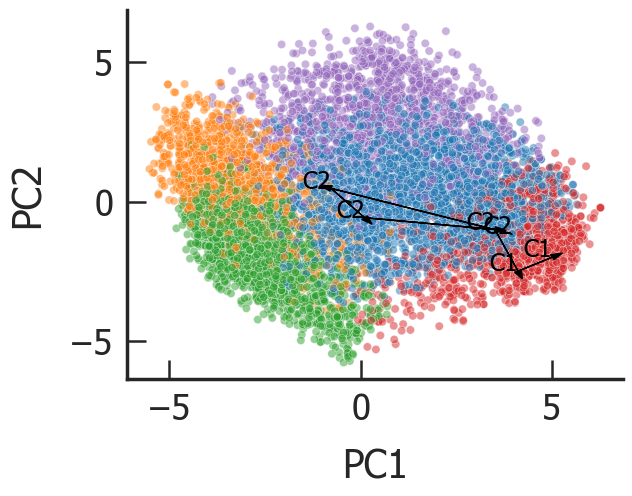

In [77]:
df = out_script_train.dropna(subset=['PC1', 'PC2', 'sofs+vtls_pred'])

patient_id = 9988  # 3098 4631
icu_stay = 1     
patient_data = df[(df['Patient_id'] == patient_id) & (df['ICU_stay'] == icu_stay)]

# Plotting the trajectory in PC space using arrows
sns.scatterplot(data=out_script_train, x='PC1', y='PC2', hue='sofs+vtls_pred', palette='tab10', legend=False, alpha=0.5)

for i in range(len(patient_data) - 1):
    start_row = patient_data.iloc[i]
    end_row = patient_data.iloc[i + 1]
    plt.arrow(start_row['PC1'], start_row['PC2'],
              end_row['PC1'] - start_row['PC1'],
              end_row['PC2'] - start_row['PC2'],
              head_width=0.2, head_length=0.3, fc='black', ec='black')

# Annotating states (sofs+vtls_pred) at each step
for i in range(len(patient_data)):
    row = patient_data.iloc[i]
    plt.text(row['PC1'], row['PC2'], row['sofs+vtls_pred'], fontsize=18, ha='right', color='black')

# plt.title(f'Trajectory in PC space for Patient ID: {patient_id}, ICU Stay: {icu_stay}')
plt.xlabel('PC1')
plt.ylabel('PC2')
# plt.grid(True)
plt.show()